# Define Google Drive location

In [1]:
from google.colab import drive
# drive.mount("/content/gdrive", force_remount=True)
drive.mount("/content/gdrive")
drive_path = '/content/gdrive/MyDrive'

from pathlib import Path

save_root = Path(drive_path) / "starCAManim"

Mounted at /content/gdrive


Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Medical Image Classification Tutorial with the MedNIST Dataset

In this tutorial, we introduce an end-to-end training and evaluation example based on the MedNIST dataset.

We'll go through the following steps:
* Create a dataset for training and testing
* Use MONAI transforms to pre-process data
* Use the DenseNet from MONAI for classification
* Train the model with a PyTorch program
* Evaluate on test dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb)

## Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.3 MB/s eta 0:00:00


## Setup imports

In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, ResNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.3.dev2340
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8d89083eeb8005babd7b5f76df83c1c80276cc10
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.3
Pillow version: 9.4.0
Tensorboard version: 2.13.0
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optiona

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
os.environ["MONAI_DATA_DIRECTORY"] = "/content/"

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/


## Download dataset

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

If you use the MedNIST dataset, please acknowledge the source.

In [6]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:01, 33.5MB/s]                            

2023-10-05 04:39:47,315 - INFO - Downloaded: /content/MedNIST.tar.gz


2023-10-05 04:39:47,776 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-10-05 04:39:47,790 - INFO - Writing into directory: /content/.


## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)

## Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.  
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,  
which should be used as the labels to train our classification model.

In [8]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Randomly pick images from the dataset to visualize and check

/content/MedNIST/AbdomenCT/008824.jpeg
/content/MedNIST/Hand/005636.jpeg
/content/MedNIST/Hand/000613.jpeg
/content/MedNIST/HeadCT/002573.jpeg
/content/MedNIST/Hand/000974.jpeg
/content/MedNIST/CXR/002077.jpeg
/content/MedNIST/ChestCT/008200.jpeg
/content/MedNIST/ChestCT/001784.jpeg
/content/MedNIST/Hand/002362.jpeg


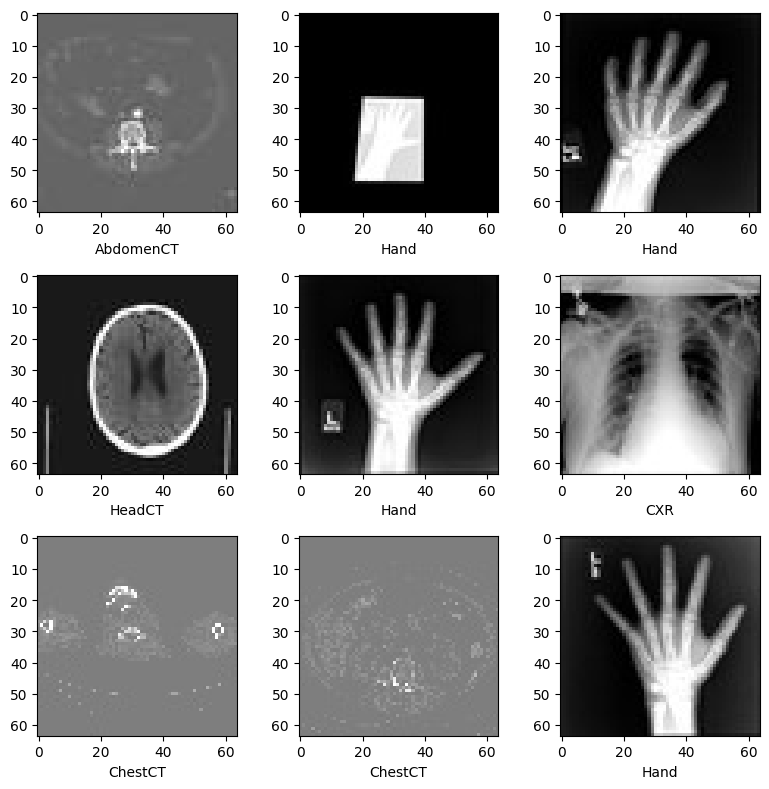

In [9]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    print(image_files_list[k])
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test.

In [10]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


In [11]:
print(test_x)

['/content/MedNIST/AbdomenCT/005308.jpeg', '/content/MedNIST/Hand/000133.jpeg', '/content/MedNIST/CXR/007661.jpeg', '/content/MedNIST/Hand/006036.jpeg', '/content/MedNIST/CXR/002973.jpeg', '/content/MedNIST/CXR/001851.jpeg', '/content/MedNIST/AbdomenCT/007433.jpeg', '/content/MedNIST/HeadCT/004287.jpeg', '/content/MedNIST/ChestCT/008741.jpeg', '/content/MedNIST/CXR/003072.jpeg', '/content/MedNIST/Hand/001137.jpeg', '/content/MedNIST/ChestCT/009979.jpeg', '/content/MedNIST/AbdomenCT/002704.jpeg', '/content/MedNIST/Hand/001799.jpeg', '/content/MedNIST/BreastMRI/007045.jpeg', '/content/MedNIST/Hand/001568.jpeg', '/content/MedNIST/CXR/008303.jpeg', '/content/MedNIST/ChestCT/000842.jpeg', '/content/MedNIST/AbdomenCT/009921.jpeg', '/content/MedNIST/AbdomenCT/008862.jpeg', '/content/MedNIST/ChestCT/004945.jpeg', '/content/MedNIST/ChestCT/002345.jpeg', '/content/MedNIST/ChestCT/004273.jpeg', '/content/MedNIST/CXR/008059.jpeg', '/content/MedNIST/AbdomenCT/008683.jpeg', '/content/MedNIST/Abdomen

## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [12]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [13]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index], self.image_files[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
And as this is just a get start tutorial, let's just train 4 epochs.  
If train 10 epochs, the model can achieve 100% accuracy on test dataset.
1. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class, growth_rate=16).to(device)
# model = ResNet(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [17]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/157, train_loss: 1.8429
2/157, train_loss: 1.8085
3/157, train_loss: 1.8100
4/157, train_loss: 1.7991
5/157, train_loss: 1.8123
6/157, train_loss: 1.7817
7/157, train_loss: 1.7660
8/157, train_loss: 1.7795
9/157, train_loss: 1.7613
10/157, train_loss: 1.7379
11/157, train_loss: 1.7148
12/157, train_loss: 1.7178
13/157, train_loss: 1.6998
14/157, train_loss: 1.7050
15/157, train_loss: 1.6764
16/157, train_loss: 1.6641
17/157, train_loss: 1.6417
18/157, train_loss: 1.6370
19/157, train_loss: 1.6760
20/157, train_loss: 1.6664
21/157, train_loss: 1.6368
22/157, train_loss: 1.6258
23/157, train_loss: 1.6337
24/157, train_loss: 1.6267
25/157, train_loss: 1.5836
26/157, train_loss: 1.5694
27/157, train_loss: 1.5775
28/157, train_loss: 1.5418
29/157, train_loss: 1.5634
30/157, train_loss: 1.5470
31/157, train_loss: 1.5290
32/157, train_loss: 1.5214
33/157, train_loss: 1.5380
34/157, train_loss: 1.4805
35/157, train_loss: 1.5009
36/157, train_loss: 1.4971
37/157, train_lo

## Plot the loss and metric

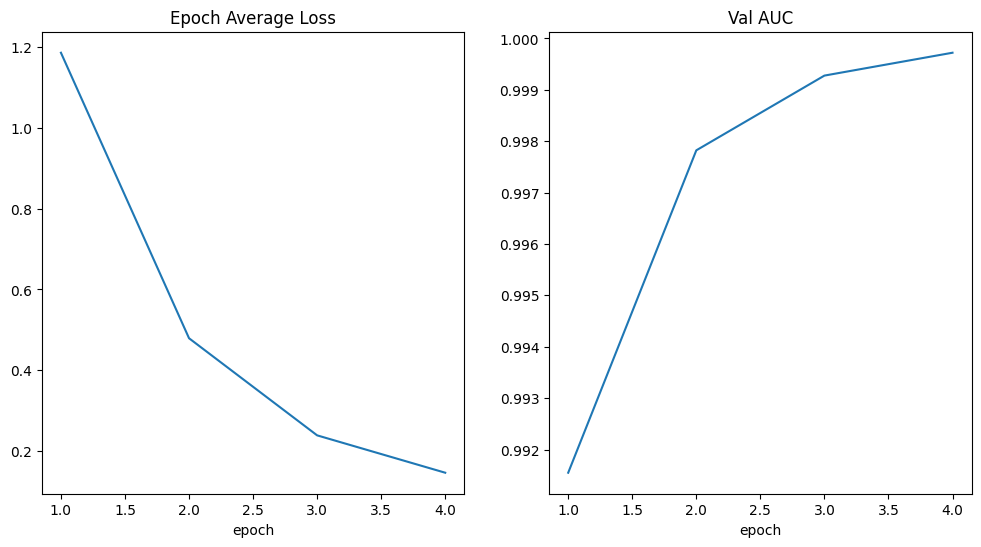

In [18]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.  
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [19]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
  for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [20]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9727    0.9678    0.9703       995
   BreastMRI     0.9819    0.9841    0.9830       880
         CXR     0.9979    0.9888    0.9934       982
     ChestCT     0.9826    1.0000    0.9912      1014
        Hand     0.9895    0.9885    0.9890      1048
      HeadCT     0.9732    0.9682    0.9707       976

    accuracy                         0.9830      5895
   macro avg     0.9830    0.9829    0.9829      5895
weighted avg     0.9830    0.9830    0.9830      5895



# Save Experiment Data on GDrive

In [15]:
dataset_name = 'MedNIST'
model_name = "DenseNet121"

# param_str = ""
param_str = "growth_rate:16"

In [16]:
experiment_save_root = save_root / dataset_name / model_name

Save trained model

In [17]:
import shutil

# Define the source and destination paths
src_path = str(os.path.join(root_dir, "best_metric_model.pth"))

dst_path = experiment_save_root / f"best_metric_model({param_str}).pth"
dst_path.parent.mkdir(parents=True, exist_ok=True)

print(src_path)
print(dst_path)
# Copy the file to the destination
shutil.copy(src_path, str(dst_path))

/content/best_metric_model.pth
/content/gdrive/MyDrive/starCAManim/MedNIST/DenseNet121/best_metric_model(growth_rate:16).pth


FileNotFoundError: ignored

save data loaders


this preserves the datasplits

In [18]:
import pickle

# Save the data loaders to pickle files
with open(experiment_save_root / 'train_loader.pkl', 'wb') as f:
    pickle.dump(train_loader, f)

with open(experiment_save_root / 'val_loader.pkl', 'wb') as f:
    pickle.dump(val_loader, f)

with open(experiment_save_root / 'test_loader.pkl', 'wb') as f:
    pickle.dump(test_loader, f)



# CAManim

## Environment setup

In [19]:
!pwd

/content


In [20]:
!ffmpeg -version

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-l

In [21]:
!pip install memory_profiler
%load_ext memory_profiler

Install CAManim repo

In [22]:
!git clone https://github.com/OMNI-ML/pytorch-grad-cam-anim.git
!ls

# the % command makes the cd last beyond this cell / line
%cd pytorch-grad-cam-anim

# switch branch
!git checkout adapt-basecam-to-support-cam_anim
!ls

Cloning into 'pytorch-grad-cam-anim'...
remote: Enumerating objects: 4654, done.
remote: Counting objects: 100% (3628/3628), done.
remote: Compressing objects: 100% (351/351), done.
remote: Total 4654 (delta 3038), reused 3572 (delta 2984), pack-reused 1026
Receiving objects: 100% (4654/4654), 1.07 GiB | 37.70 MiB/s, done.
Resolving deltas: 100% (3604/3604), done.
gdrive	MedNIST  MedNIST.tar.gz  pytorch-grad-cam-anim	sample_data
/content/pytorch-grad-cam-anim
Branch 'adapt-basecam-to-support-cam_anim' set up to track remote branch 'adapt-basecam-to-support-cam_anim' from 'origin'.
Switched to a new branch 'adapt-basecam-to-support-cam_anim'
_CAManim_animating_end2end_activation_maps.ipynb  requirements_CAManim.txt
cam.py						  requirements.txt
examples					  setup.cfg
LICENSE						  setup.py
pyproject.toml					  tests
pytorch_grad_cam				  tutorials
README.md					  usage_examples


In [23]:
!git log --oneline --max-count=10 # --reverse

c69a6b4 (HEAD -> adapt-basecam-to-support-cam_anim, origin/adapt-basecam-to-support-cam_anim) added garbage collections to help RAM usage
3421f3e Merge branch 'adapt-basecam-to-support-cam_anim' of https://github.com/OMNI-ML/pytorch-grad-cam-anim into adapt-basecam-to-support-cam_anim
8cd9887 implemented memory offloading to reduce RAM
3bf5a0c Created using Colaboratory
2dec3b2 added additional print statements to confirm normalization
34f6631 fixed bug related to video naming
f97ed28 resaved notebook
45ec5b7 started local/repo notebook for CAManim
79dbfc3 changed _ffmpeg methods to use subprocess instead
ff9ffb4 fixed bug related to folder not created


In [24]:
# !python setup.py install - avoid this
!pip install .
!pip install -r requirements_CAManim.txt
# !pip install ffmpeg-python

Processing /content/pytorch-grad-cam-anim
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=44596 sha256=13f633de26914b7cfc6303c4a09eaef79bff66b0808289725a6d154fb4a28b01
  Stored in directory: /root/.cache/pip/wheels/5e/e9/6a/e6fc4e1d28c7938e9ff20505457d082d0fb87579dfe1f61668
Successfully built grad-cam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=50a9becd945f3d695b4f0b218bf56dcc21284a050a3b630978bc7bd54ebcf155
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


Imports

In [25]:
import pandas as pd
import json
import pickle
import torch

## Define CAMs list

In [26]:
# from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam import EigenCAM, \
                              EigenGradCAM, \
                              FullGrad, \
                              GradCAM, \
                              GradCAMElementWise, \
                              GradCAMPlusPlus, \
                              HiResCAM, \
                              LayerCAM, \
                              RandomCAM, \
                              ScoreCAM, \
                              XGradCAM, \
                              AblationCAM


cams_list = [#'AblationCAM', # ran out of RAM
            # 'GradCAM',
            'HiResCAM',
            'GradCAMElementWise',
            'GradCAMPlusPlus',
            'EigenCAM', # done
            #'EigenGradCAM', # Skipped all layers for AlexNet; figure out
            'RandomCAM',
            'LayerCAM',
             'XGradCAM',
             #'FullGrad', # Skipped all layers for DenseNet161; figure out
             #'ScoreCAM', # ran out of RAM
             ]

In [27]:
# cams_list = ['AblationCAM']#['HiResCAM']#['GradCAM']

## Load Image

In [28]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index], self.image_files[index]

In [29]:
# Load the data loaders from the pickle files
with open(experiment_save_root / 'train_loader.pkl', 'rb') as f:
    train_loader = pickle.load(f)

with open(experiment_save_root / 'val_loader.pkl', 'rb') as f:
    val_loader = pickle.load(f)

with open(experiment_save_root / 'test_loader.pkl', 'rb') as f:
    test_loader = pickle.load(f)

In [30]:

y_true = []
y_pred = []
#with torch.no_grad():
found = False
for test_data in test_loader:
    test_images, test_labels, test_paths = (
        test_data[0].to(device),
        test_data[1].to(device),
        test_data[2]
    )

    for img_id, img_path in enumerate(test_paths):

      # if "/content/MedNIST/Hand/008908.jpeg" == img_path:
      if "Hand" in img_path:# and "008908" in img_path:
        found = True
        break
      # if "Hand" in img_path:
      #   found = True
      #   break

    if found:
      break


# img_id = 2

# "/content/MedNIST/Hand/008908.jpeg"

#target_layers = get_target_layers(model)
input_tensor = torch.unsqueeze(test_images[img_id], 0)
input_tensor.requires_grad_(True)
img = np.array(PIL.Image.open(test_paths[img_id]))
img = np.expand_dims((np.float32(img) / 255), axis=2)
print(img.shape)
print(test_paths[img_id])

(64, 64, 1)
/content/MedNIST/Hand/000133.jpeg


## Load Models Dictionary

In [31]:
dataset_name = 'MedNIST'
model_name = "DenseNet121"
# param_str = ""
param_str = "growth_rate:16"

# experiment_save_root = save_root / dataset_name / model_name
model_path = str(save_root / dataset_name / model_name / f"best_metric_model({param_str}).pth")
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
# model_name = 'MedNet'

models_dict = {
                f"{dataset_name}_{model_name}({param_str})": model
              }

### visualize model parameters

In [32]:
model_key = list(models_dict.keys())[0] # pick first model in dictionary
print(model_key)

model = models_dict[model_key]
layers = [layer for layer, what_is_this in model.named_modules()]
print(len(layers))
parameters = [p for p in model.parameters()]# if p.requires_grad]
len(parameters)

MedNIST_DenseNet121(growth_rate:16)
495


364

In [33]:
running_sum = 0

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

for layer_name, layer_module in model.named_modules():

  # print("-"*6 + layer_name + "-"*6)
  # print(type(layer_name))
  # print(type(layer_module))
  # layer_parameters = [parameters = [p for p in model.parameters()]# if p.requires_grad]]
  n_layer_params = sum(p.numel() for p in layer_module.parameters() if p.requires_grad)
  running_sum += n_layer_params

print(running_sum)
print(total_params)

10515890
1818646


## CAManim Loop

### utils

In [34]:
import gc
gc.enable()
print(gc.collect())
print(pd.DataFrame.from_records(gc.get_stats()))

27417
   collections  collected  uncollectable
0         1848       7719              0
1          167       2327              0
2           11      27624              0


In [35]:
def get_target_layers(model):
  """
  target_layers doesn't matter for cam_anim (since we loop through all the layers),
  but it is needed for initializing the GradCAM object.
  This method returns the last layer (that is viable as a target i.e. iterable) of the model.

  """


  target_layers = []
  for _, layer_module in model.named_modules():
    # print(_)
    if _ == "features.Mixed_7c.branch_pool.conv":
      target_layers.append(layer_module)
    # https://stackoverflow.com/questions/1952464/in-python-how-do-i-determine-if-an-object-is-iterable
    try:
      some_object_iterator = iter(layer_module)
      if type(layer_module)!=str:
        target_layers.append(layer_module)

    except TypeError as te:
      pass
      # print(some_object, 'is not iterable')
  # target_layers = target_layers[-2]
  print(target_layers[-1])
  return [target_layers[-1]]

### loop

In [36]:
n_models = len(models_dict.keys())
n_cams = len(cams_list)

print(f"{n_models} X {n_cams} = {n_models*n_cams} iterations")

1 X 7 = 7 iterations


In [ ]:
metrics_records = []
for model_name, model in models_dict.items():

  print("="*33 + model_name + "="*33)

  outdir = save_root / model_name
  outdir.mkdir(exist_ok=True, parents= True)

  target_layers = get_target_layers(model)
  # target_layers = ["features.Mixed_7c.branch_pool.conv"]

  for cam_name in cams_list:
    print("-"*33 + cam_name + "-"*33)

    frames_dir = outdir / cam_name
    frames_dir.mkdir(exist_ok=True, parents= True)
    metrics = {"model_name": model_name, "CAM Name": cam_name, "error": None}
    try:
      cam = globals()[cam_name](model=model, target_layers=target_layers, use_cuda=False)
      metrics_update = cam.cam_anim(img,
                                    input_tensor,
                                    frame_rate=24,
                                    norm_type='both',
                                    keep_frames=True,
                                    tmp_dir=str(frames_dir),
                                    output_fname=str(outdir / f"{cam_name}_anim.mp4"))

      metrics.update(metrics_update)
      del cam
      gc.collect()
      print(pd.DataFrame.from_records(gc.get_stats()))
      print(f"{cam_name} Finished")


    except Exception as ex:
      metrics.update({"error": str(ex)})
      print(ex)
      print("Continuing to the next CAM")
      raise ex

    metrics_records.append(metrics)

    with open(str(outdir / f"metrics_logs.json"), "w") as outfile:
      json.dump(metrics_records, outfile, indent=4)

=================================MedNIST_DenseNet121(growth_rate:16)=================================
Sequential(
  (relu): ReLU(inplace=True)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=516, out_features=6, bias=True)
)
---------------------------------HiResCAM---------------------------------
/content/gdrive/MyDrive/starCAManim/MedNIST_DenseNet121(growth_rate:16)/HiResCAM/


Model Layer Loop - features:   0%|          | 0/495 [00:00<?, ?it/s]

skipping 
'DenseNet121' object has no attribute ''


Model Layer Loop - features.conv0:   0%|          | 2/495 [00:14<1:00:48,  7.40s/it]

skipping features
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.norm0:   1%|          | 3/495 [00:16<41:04,  5.01s/it]

0


Model Layer Loop - features.relu0:   1%|          | 4/495 [00:16<27:09,  3.32s/it]

skipping features.norm0
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.pool0:   1%|          | 5/495 [00:18<22:09,  2.71s/it]

0


Model Layer Loop - features.denseblock1:   1%|          | 6/495 [00:20<19:35,  2.40s/it]

0


Model Layer Loop - features.denseblock1.denselayer1:   1%|▏         | 7/495 [00:22<18:05,  2.22s/it]

0


Model Layer Loop - features.denseblock1.denselayer1.layers:   2%|▏         | 8/495 [00:25<21:36,  2.66s/it]

0


Model Layer Loop - features.denseblock1.denselayer1.layers.norm1:   2%|▏         | 9/495 [00:29<24:45,  3.06s/it]

0


Model Layer Loop - features.denseblock1.denselayer1.layers.relu1:   2%|▏         | 10/495 [00:30<18:46,  2.32s/it]

skipping features.denseblock1.denselayer1.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer1.layers.conv1:   2%|▏         | 11/495 [00:32<18:56,  2.35s/it]

0


Model Layer Loop - features.denseblock1.denselayer1.layers.norm2:   2%|▏         | 12/495 [00:35<18:39,  2.32s/it]

0


Model Layer Loop - features.denseblock1.denselayer1.layers.relu2:   3%|▎         | 13/495 [00:35<14:10,  1.76s/it]

skipping features.denseblock1.denselayer1.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer1.layers.conv2:   3%|▎         | 14/495 [00:37<15:32,  1.94s/it]

0


Model Layer Loop - features.denseblock1.denselayer2:   3%|▎         | 15/495 [00:40<16:12,  2.03s/it]

0


Model Layer Loop - features.denseblock1.denselayer2.layers:   3%|▎         | 16/495 [00:43<20:05,  2.52s/it]

0


Model Layer Loop - features.denseblock1.denselayer2.layers.norm1:   3%|▎         | 17/495 [00:46<20:04,  2.52s/it]

0


Model Layer Loop - features.denseblock1.denselayer2.layers.relu1:   4%|▎         | 18/495 [00:46<14:47,  1.86s/it]

skipping features.denseblock1.denselayer2.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer2.layers.conv1:   4%|▍         | 19/495 [00:47<12:38,  1.59s/it]

0


Model Layer Loop - features.denseblock1.denselayer2.layers.norm2:   4%|▍         | 20/495 [00:48<11:44,  1.48s/it]

0


Model Layer Loop - features.denseblock1.denselayer2.layers.relu2:   4%|▍         | 21/495 [00:49<09:10,  1.16s/it]

skipping features.denseblock1.denselayer2.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer2.layers.conv2:   4%|▍         | 22/495 [00:50<08:43,  1.11s/it]

0


Model Layer Loop - features.denseblock1.denselayer3:   5%|▍         | 23/495 [00:51<08:48,  1.12s/it]

0


Model Layer Loop - features.denseblock1.denselayer3.layers:   5%|▍         | 24/495 [00:52<08:20,  1.06s/it]

0


Model Layer Loop - features.denseblock1.denselayer3.layers.relu1:   5%|▌         | 26/495 [00:53<05:27,  1.43it/s]

0
skipping features.denseblock1.denselayer3.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer3.layers.conv1:   5%|▌         | 27/495 [00:53<05:07,  1.52it/s]

0


Model Layer Loop - features.denseblock1.denselayer3.layers.relu2:   6%|▌         | 29/495 [00:54<04:39,  1.67it/s]

0
skipping features.denseblock1.denselayer3.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer3.layers.conv2:   6%|▌         | 30/495 [00:55<05:48,  1.33it/s]

0


Model Layer Loop - features.denseblock1.denselayer4:   6%|▋         | 31/495 [00:57<07:19,  1.06it/s]

0


Model Layer Loop - features.denseblock1.denselayer4.layers:   6%|▋         | 32/495 [00:58<07:02,  1.10it/s]

0


Model Layer Loop - features.denseblock1.denselayer4.layers.relu1:   7%|▋         | 34/495 [00:58<04:28,  1.71it/s]

0
skipping features.denseblock1.denselayer4.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer4.layers.conv1:   7%|▋         | 35/495 [00:59<04:14,  1.81it/s]

0


Model Layer Loop - features.denseblock1.denselayer4.layers.relu2:   7%|▋         | 37/495 [00:59<03:09,  2.42it/s]

0
skipping features.denseblock1.denselayer4.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer4.layers.conv2:   8%|▊         | 38/495 [01:00<03:20,  2.28it/s]

0


Model Layer Loop - features.denseblock1.denselayer5:   8%|▊         | 39/495 [01:00<03:21,  2.27it/s]

0


Model Layer Loop - features.denseblock1.denselayer5.layers:   8%|▊         | 40/495 [01:01<03:12,  2.36it/s]

0


Model Layer Loop - features.denseblock1.denselayer5.layers.relu1:   8%|▊         | 42/495 [01:01<02:23,  3.16it/s]

0
skipping features.denseblock1.denselayer5.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer5.layers.conv1:   9%|▊         | 43/495 [01:02<02:30,  3.01it/s]

0


Model Layer Loop - features.denseblock1.denselayer5.layers.relu2:   9%|▉         | 45/495 [01:02<02:03,  3.66it/s]

0
skipping features.denseblock1.denselayer5.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer5.layers.conv2:   9%|▉         | 46/495 [01:02<02:17,  3.27it/s]

0


Model Layer Loop - features.denseblock1.denselayer6:   9%|▉         | 47/495 [01:03<02:26,  3.05it/s]

0


Model Layer Loop - features.denseblock1.denselayer6.layers:  10%|▉         | 48/495 [01:03<02:32,  2.93it/s]

0


Model Layer Loop - features.denseblock1.denselayer6.layers.relu1:  10%|█         | 50/495 [01:04<02:07,  3.49it/s]

0
skipping features.denseblock1.denselayer6.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer6.layers.conv1:  10%|█         | 51/495 [01:04<02:28,  2.99it/s]

0


Model Layer Loop - features.denseblock1.denselayer6.layers.relu2:  11%|█         | 52/495 [01:05<02:31,  2.92it/s]

0
skipping features.denseblock1.denselayer6.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer6.layers.conv2:  11%|█         | 54/495 [01:05<02:09,  3.40it/s]

0


Model Layer Loop - features.transition1:  11%|█         | 55/495 [01:05<02:17,  3.19it/s]

0


Model Layer Loop - features.transition1.relu:  11%|█▏        | 56/495 [01:06<02:23,  3.05it/s]

0
skipping features.transition1.norm
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.transition1.conv:  12%|█▏        | 58/495 [01:06<02:03,  3.53it/s]

0


Model Layer Loop - features.transition1.pool:  12%|█▏        | 59/495 [01:07<02:12,  3.29it/s]

0


Model Layer Loop - features.denseblock2:  12%|█▏        | 60/495 [01:07<02:19,  3.11it/s]

0


Model Layer Loop - features.denseblock2.denselayer1:  12%|█▏        | 61/495 [01:07<02:23,  3.02it/s]

0


Model Layer Loop - features.denseblock2.denselayer1.layers:  13%|█▎        | 62/495 [01:08<02:27,  2.94it/s]

0


Model Layer Loop - features.denseblock2.denselayer1.layers.relu1:  13%|█▎        | 63/495 [01:08<02:29,  2.88it/s]

0
skipping features.denseblock2.denselayer1.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer1.layers.conv1:  13%|█▎        | 65/495 [01:08<02:06,  3.40it/s]

0


Model Layer Loop - features.denseblock2.denselayer1.layers.relu2:  13%|█▎        | 66/495 [01:09<02:12,  3.24it/s]

0
skipping features.denseblock2.denselayer1.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer1.layers.conv2:  14%|█▎        | 68/495 [01:09<01:59,  3.57it/s]

0


Model Layer Loop - features.denseblock2.denselayer2:  14%|█▍        | 69/495 [01:10<02:09,  3.29it/s]

0


Model Layer Loop - features.denseblock2.denselayer2.layers:  14%|█▍        | 70/495 [01:10<02:17,  3.09it/s]

0


Model Layer Loop - features.denseblock2.denselayer2.layers.relu1:  15%|█▍        | 72/495 [01:11<02:06,  3.35it/s]

0
skipping features.denseblock2.denselayer2.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer2.layers.conv1:  15%|█▍        | 73/495 [01:11<02:28,  2.85it/s]

0


Model Layer Loop - features.denseblock2.denselayer2.layers.relu2:  15%|█▌        | 75/495 [01:12<02:11,  3.19it/s]

0
skipping features.denseblock2.denselayer2.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer2.layers.conv2:  15%|█▌        | 76/495 [01:12<02:30,  2.79it/s]

0


Model Layer Loop - features.denseblock2.denselayer3:  16%|█▌        | 77/495 [01:13<02:47,  2.50it/s]

0


Model Layer Loop - features.denseblock2.denselayer3.layers:  16%|█▌        | 78/495 [01:13<02:55,  2.38it/s]

0


Model Layer Loop - features.denseblock2.denselayer3.layers.relu1:  16%|█▌        | 80/495 [01:14<02:25,  2.85it/s]

0
skipping features.denseblock2.denselayer3.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer3.layers.conv1:  16%|█▋        | 81/495 [01:14<02:46,  2.49it/s]

0


Model Layer Loop - features.denseblock2.denselayer3.layers.relu2:  17%|█▋        | 83/495 [01:15<02:12,  3.11it/s]

0
skipping features.denseblock2.denselayer3.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer3.layers.conv2:  17%|█▋        | 84/495 [01:15<02:20,  2.93it/s]

0


Model Layer Loop - features.denseblock2.denselayer4:  17%|█▋        | 85/495 [01:16<02:26,  2.80it/s]

0


Model Layer Loop - features.denseblock2.denselayer4.layers:  17%|█▋        | 86/495 [01:16<02:28,  2.76it/s]

0


Model Layer Loop - features.denseblock2.denselayer4.layers.relu1:  18%|█▊        | 87/495 [01:16<02:29,  2.72it/s]

0
skipping features.denseblock2.denselayer4.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer4.layers.conv1:  18%|█▊        | 89/495 [01:17<02:04,  3.27it/s]

0


Model Layer Loop - features.denseblock2.denselayer4.layers.relu2:  18%|█▊        | 91/495 [01:17<01:47,  3.75it/s]

0
skipping features.denseblock2.denselayer4.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer4.layers.conv2:  19%|█▊        | 92/495 [01:18<02:01,  3.32it/s]

0


Model Layer Loop - features.denseblock2.denselayer5:  19%|█▉        | 93/495 [01:18<02:10,  3.09it/s]

0


Model Layer Loop - features.denseblock2.denselayer5.layers:  19%|█▉        | 94/495 [01:19<02:16,  2.93it/s]

0


Model Layer Loop - features.denseblock2.denselayer5.layers.relu1:  19%|█▉        | 96/495 [01:19<01:52,  3.56it/s]

0
skipping features.denseblock2.denselayer5.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer5.layers.conv1:  20%|█▉        | 97/495 [01:19<02:03,  3.21it/s]

0


Model Layer Loop - features.denseblock2.denselayer5.layers.relu2:  20%|██        | 99/495 [01:20<01:45,  3.74it/s]

0
skipping features.denseblock2.denselayer5.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer5.layers.conv2:  20%|██        | 100/495 [01:20<01:58,  3.32it/s]

0


Model Layer Loop - features.denseblock2.denselayer6:  20%|██        | 101/495 [01:21<02:08,  3.07it/s]

0


Model Layer Loop - features.denseblock2.denselayer6.layers:  21%|██        | 102/495 [01:21<02:15,  2.90it/s]

0


Model Layer Loop - features.denseblock2.denselayer6.layers.relu1:  21%|██        | 103/495 [01:22<02:20,  2.79it/s]

0
skipping features.denseblock2.denselayer6.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer6.layers.conv1:  21%|██        | 105/495 [01:22<01:58,  3.29it/s]

0


Model Layer Loop - features.denseblock2.denselayer6.layers.relu2:  22%|██▏       | 107/495 [01:22<01:43,  3.74it/s]

0
skipping features.denseblock2.denselayer6.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer6.layers.conv2:  22%|██▏       | 108/495 [01:23<01:56,  3.32it/s]

0


Model Layer Loop - features.denseblock2.denselayer7:  22%|██▏       | 109/495 [01:23<02:08,  3.01it/s]

0


Model Layer Loop - features.denseblock2.denselayer7.layers:  22%|██▏       | 110/495 [01:24<02:14,  2.86it/s]

0


Model Layer Loop - features.denseblock2.denselayer7.layers.relu1:  23%|██▎       | 112/495 [01:24<01:49,  3.51it/s]

0
skipping features.denseblock2.denselayer7.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer7.layers.conv1:  23%|██▎       | 113/495 [01:24<02:01,  3.14it/s]

0


Model Layer Loop - features.denseblock2.denselayer7.layers.relu2:  23%|██▎       | 115/495 [01:25<01:53,  3.34it/s]

0
skipping features.denseblock2.denselayer7.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer7.layers.conv2:  23%|██▎       | 116/495 [01:26<02:16,  2.78it/s]

0


Model Layer Loop - features.denseblock2.denselayer8:  24%|██▎       | 117/495 [01:26<02:30,  2.51it/s]

0


Model Layer Loop - features.denseblock2.denselayer8.layers:  24%|██▍       | 118/495 [01:27<03:03,  2.05it/s]

0


Model Layer Loop - features.denseblock2.denselayer8.layers.relu1:  24%|██▍       | 120/495 [01:27<02:24,  2.59it/s]

0
skipping features.denseblock2.denselayer8.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer8.layers.conv1:  24%|██▍       | 121/495 [01:28<02:38,  2.36it/s]

0


Model Layer Loop - features.denseblock2.denselayer8.layers.relu2:  25%|██▍       | 123/495 [01:29<02:14,  2.78it/s]

0
skipping features.denseblock2.denselayer8.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer8.layers.conv2:  25%|██▌       | 124/495 [01:29<02:25,  2.55it/s]

0


Model Layer Loop - features.denseblock2.denselayer9:  25%|██▌       | 125/495 [01:29<02:24,  2.56it/s]

0


Model Layer Loop - features.denseblock2.denselayer9.layers:  25%|██▌       | 126/495 [01:30<02:23,  2.56it/s]

0


Model Layer Loop - features.denseblock2.denselayer9.layers.relu1:  26%|██▌       | 128/495 [01:30<01:52,  3.28it/s]

0
skipping features.denseblock2.denselayer9.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer9.layers.conv1:  26%|██▌       | 129/495 [01:31<02:01,  3.01it/s]

0


Model Layer Loop - features.denseblock2.denselayer9.layers.relu2:  26%|██▋       | 131/495 [01:31<01:40,  3.63it/s]

0
skipping features.denseblock2.denselayer9.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer9.layers.conv2:  27%|██▋       | 132/495 [01:32<01:52,  3.23it/s]

0


Model Layer Loop - features.denseblock2.denselayer10:  27%|██▋       | 133/495 [01:32<02:01,  2.98it/s]

0


Model Layer Loop - features.denseblock2.denselayer10.layers:  27%|██▋       | 134/495 [01:32<02:06,  2.86it/s]

0


Model Layer Loop - features.denseblock2.denselayer10.layers.relu1:  27%|██▋       | 136/495 [01:33<01:41,  3.54it/s]

0
skipping features.denseblock2.denselayer10.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer10.layers.conv1:  28%|██▊       | 137/495 [01:33<01:53,  3.17it/s]

0


Model Layer Loop - features.denseblock2.denselayer10.layers.relu2:  28%|██▊       | 139/495 [01:34<01:35,  3.73it/s]

0
skipping features.denseblock2.denselayer10.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer10.layers.conv2:  28%|██▊       | 140/495 [01:34<01:48,  3.28it/s]

0


Model Layer Loop - features.denseblock2.denselayer11:  28%|██▊       | 141/495 [01:35<01:57,  3.02it/s]

0


Model Layer Loop - features.denseblock2.denselayer11.layers:  29%|██▊       | 142/495 [01:35<02:05,  2.81it/s]

0


Model Layer Loop - features.denseblock2.denselayer11.layers.relu1:  29%|██▉       | 144/495 [01:36<01:43,  3.39it/s]

0
skipping features.denseblock2.denselayer11.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer11.layers.conv1:  29%|██▉       | 145/495 [01:36<01:54,  3.06it/s]

0


Model Layer Loop - features.denseblock2.denselayer11.layers.relu2:  29%|██▉       | 146/495 [01:36<02:01,  2.87it/s]

0
skipping features.denseblock2.denselayer11.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer11.layers.conv2:  30%|██▉       | 148/495 [01:37<01:43,  3.34it/s]

0


Model Layer Loop - features.denseblock2.denselayer12:  30%|███       | 149/495 [01:37<01:51,  3.10it/s]

0


Model Layer Loop - features.denseblock2.denselayer12.layers:  30%|███       | 150/495 [01:38<01:57,  2.93it/s]

0


Model Layer Loop - features.denseblock2.denselayer12.layers.relu1:  31%|███       | 152/495 [01:38<01:37,  3.51it/s]

0
skipping features.denseblock2.denselayer12.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer12.layers.conv1:  31%|███       | 153/495 [01:38<01:48,  3.14it/s]

0


Model Layer Loop - features.denseblock2.denselayer12.layers.relu2:  31%|███▏      | 155/495 [01:39<01:37,  3.49it/s]

0
skipping features.denseblock2.denselayer12.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer12.layers.conv2:  32%|███▏      | 156/495 [01:40<01:57,  2.89it/s]

0


Model Layer Loop - features.transition2:  32%|███▏      | 157/495 [01:40<02:15,  2.49it/s]

0


Model Layer Loop - features.transition2.relu:  32%|███▏      | 159/495 [01:41<01:59,  2.82it/s]

0
skipping features.transition2.norm
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.transition2.conv:  32%|███▏      | 160/495 [01:41<02:15,  2.48it/s]

0


Model Layer Loop - features.transition2.pool:  33%|███▎      | 161/495 [01:42<02:24,  2.31it/s]

0


Model Layer Loop - features.denseblock3:  33%|███▎      | 162/495 [01:42<02:32,  2.18it/s]

0


Model Layer Loop - features.denseblock3.denselayer1:  33%|███▎      | 163/495 [01:43<02:41,  2.05it/s]

0


Model Layer Loop - features.denseblock3.denselayer1.layers:  33%|███▎      | 164/495 [01:43<02:45,  2.01it/s]

0


Model Layer Loop - features.denseblock3.denselayer1.layers.relu1:  34%|███▎      | 166/495 [01:44<01:58,  2.78it/s]

0
skipping features.denseblock3.denselayer1.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer1.layers.conv1:  34%|███▎      | 167/495 [01:44<02:02,  2.68it/s]

0


Model Layer Loop - features.denseblock3.denselayer1.layers.relu2:  34%|███▍      | 169/495 [01:45<01:36,  3.37it/s]

0
skipping features.denseblock3.denselayer1.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer1.layers.conv2:  34%|███▍      | 170/495 [01:45<01:47,  3.01it/s]

0


Model Layer Loop - features.denseblock3.denselayer2:  35%|███▍      | 171/495 [01:46<01:55,  2.79it/s]

0


Model Layer Loop - features.denseblock3.denselayer2.layers:  35%|███▍      | 172/495 [01:46<01:58,  2.72it/s]

0


Model Layer Loop - features.denseblock3.denselayer2.layers.relu1:  35%|███▌      | 174/495 [01:47<01:36,  3.34it/s]

0
skipping features.denseblock3.denselayer2.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer2.layers.conv1:  35%|███▌      | 175/495 [01:47<01:45,  3.02it/s]

0


Model Layer Loop - features.denseblock3.denselayer2.layers.relu2:  36%|███▌      | 177/495 [01:47<01:29,  3.57it/s]

0
skipping features.denseblock3.denselayer2.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer2.layers.conv2:  36%|███▌      | 178/495 [01:48<01:41,  3.12it/s]

0


Model Layer Loop - features.denseblock3.denselayer3:  36%|███▌      | 179/495 [01:48<01:48,  2.91it/s]

0


Model Layer Loop - features.denseblock3.denselayer3.layers:  36%|███▋      | 180/495 [01:49<01:55,  2.73it/s]

0


Model Layer Loop - features.denseblock3.denselayer3.layers.relu1:  37%|███▋      | 182/495 [01:49<01:33,  3.34it/s]

0
skipping features.denseblock3.denselayer3.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer3.layers.conv1:  37%|███▋      | 183/495 [01:50<01:50,  2.81it/s]

0


Model Layer Loop - features.denseblock3.denselayer3.layers.relu2:  37%|███▋      | 185/495 [01:50<01:30,  3.44it/s]

0
skipping features.denseblock3.denselayer3.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer3.layers.conv2:  38%|███▊      | 186/495 [01:51<01:41,  3.06it/s]

0


Model Layer Loop - features.denseblock3.denselayer4:  38%|███▊      | 187/495 [01:51<01:46,  2.88it/s]

0


Model Layer Loop - features.denseblock3.denselayer4.layers:  38%|███▊      | 188/495 [01:51<01:50,  2.77it/s]

0


Model Layer Loop - features.denseblock3.denselayer4.layers.relu1:  38%|███▊      | 190/495 [01:52<01:32,  3.31it/s]

0
skipping features.denseblock3.denselayer4.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer4.layers.conv1:  39%|███▊      | 191/495 [01:52<01:39,  3.06it/s]

0


Model Layer Loop - features.denseblock3.denselayer4.layers.relu2:  39%|███▉      | 192/495 [01:53<01:44,  2.90it/s]

0
skipping features.denseblock3.denselayer4.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer4.layers.conv2:  39%|███▉      | 194/495 [01:53<01:31,  3.29it/s]

0


Model Layer Loop - features.denseblock3.denselayer5:  39%|███▉      | 195/495 [01:54<01:43,  2.90it/s]

0


Model Layer Loop - features.denseblock3.denselayer5.layers:  40%|███▉      | 196/495 [01:54<01:55,  2.58it/s]

0


Model Layer Loop - features.denseblock3.denselayer5.layers.relu1:  40%|████      | 198/495 [01:55<01:44,  2.85it/s]

0
skipping features.denseblock3.denselayer5.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer5.layers.conv1:  40%|████      | 199/495 [01:55<02:07,  2.33it/s]

0


Model Layer Loop - features.denseblock3.denselayer5.layers.norm2:  40%|████      | 200/495 [01:56<02:22,  2.08it/s]

0


Model Layer Loop - features.denseblock3.denselayer5.layers.relu2:  41%|████      | 201/495 [01:56<01:58,  2.48it/s]

skipping features.denseblock3.denselayer5.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer6:  41%|████      | 203/495 [01:57<02:15,  2.16it/s]

0
0


Model Layer Loop - features.denseblock3.denselayer6.layers:  41%|████      | 204/495 [01:58<02:19,  2.08it/s]

0


Model Layer Loop - features.denseblock3.denselayer6.layers.relu1:  42%|████▏     | 206/495 [01:59<01:49,  2.65it/s]

0
skipping features.denseblock3.denselayer6.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer6.layers.conv1:  42%|████▏     | 207/495 [01:59<01:51,  2.59it/s]

0


Model Layer Loop - features.denseblock3.denselayer6.layers.relu2:  42%|████▏     | 209/495 [01:59<01:28,  3.25it/s]

0
skipping features.denseblock3.denselayer6.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer6.layers.conv2:  42%|████▏     | 210/495 [02:00<01:36,  2.95it/s]

0


Model Layer Loop - features.denseblock3.denselayer7:  43%|████▎     | 211/495 [02:00<01:44,  2.72it/s]

0


Model Layer Loop - features.denseblock3.denselayer7.layers:  43%|████▎     | 212/495 [02:01<01:47,  2.63it/s]

0


Model Layer Loop - features.denseblock3.denselayer7.layers.relu1:  43%|████▎     | 214/495 [02:01<01:26,  3.26it/s]

0
skipping features.denseblock3.denselayer7.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer7.layers.conv1:  43%|████▎     | 215/495 [02:02<01:34,  2.97it/s]

0


Model Layer Loop - features.denseblock3.denselayer7.layers.relu2:  44%|████▍     | 217/495 [02:02<01:19,  3.49it/s]

0
skipping features.denseblock3.denselayer7.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer7.layers.conv2:  44%|████▍     | 218/495 [02:03<01:29,  3.09it/s]

0


Model Layer Loop - features.denseblock3.denselayer8:  44%|████▍     | 219/495 [02:03<01:35,  2.90it/s]

0


Model Layer Loop - features.denseblock3.denselayer8.layers:  44%|████▍     | 220/495 [02:03<01:40,  2.74it/s]

0


Model Layer Loop - features.denseblock3.denselayer8.layers.relu1:  45%|████▍     | 222/495 [02:04<01:21,  3.34it/s]

0
skipping features.denseblock3.denselayer8.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer8.layers.conv1:  45%|████▌     | 223/495 [02:04<01:31,  2.98it/s]

0


Model Layer Loop - features.denseblock3.denselayer8.layers.relu2:  45%|████▌     | 225/495 [02:05<01:16,  3.52it/s]

0
skipping features.denseblock3.denselayer8.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer8.layers.conv2:  46%|████▌     | 226/495 [02:05<01:26,  3.11it/s]

0


Model Layer Loop - features.denseblock3.denselayer9:  46%|████▌     | 227/495 [02:06<01:35,  2.80it/s]

0


Model Layer Loop - features.denseblock3.denselayer9.layers:  46%|████▌     | 228/495 [02:06<01:41,  2.62it/s]

0


Model Layer Loop - features.denseblock3.denselayer9.layers.relu1:  46%|████▋     | 230/495 [02:07<01:22,  3.23it/s]

0
skipping features.denseblock3.denselayer9.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer9.layers.conv1:  47%|████▋     | 231/495 [02:07<01:31,  2.87it/s]

0


Model Layer Loop - features.denseblock3.denselayer9.layers.relu2:  47%|████▋     | 233/495 [02:08<01:18,  3.35it/s]

0
skipping features.denseblock3.denselayer9.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer9.layers.conv2:  47%|████▋     | 234/495 [02:08<01:27,  2.97it/s]

0


Model Layer Loop - features.denseblock3.denselayer10:  47%|████▋     | 235/495 [02:09<01:39,  2.61it/s]

0


Model Layer Loop - features.denseblock3.denselayer10.layers:  48%|████▊     | 236/495 [02:09<01:52,  2.30it/s]

0


Model Layer Loop - features.denseblock3.denselayer10.layers.relu1:  48%|████▊     | 238/495 [02:10<01:36,  2.66it/s]

0
skipping features.denseblock3.denselayer10.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer10.layers.conv1:  48%|████▊     | 239/495 [02:10<01:53,  2.26it/s]

0


Model Layer Loop - features.denseblock3.denselayer10.layers.relu2:  49%|████▊     | 241/495 [02:11<01:36,  2.63it/s]

0
skipping features.denseblock3.denselayer10.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer10.layers.conv2:  49%|████▉     | 242/495 [02:12<01:49,  2.31it/s]

0


Model Layer Loop - features.denseblock3.denselayer11:  49%|████▉     | 243/495 [02:12<01:56,  2.17it/s]

0


Model Layer Loop - features.denseblock3.denselayer11.layers:  49%|████▉     | 244/495 [02:13<02:36,  1.60it/s]

0


Model Layer Loop - features.denseblock3.denselayer11.layers.norm1:  49%|████▉     | 245/495 [02:14<02:21,  1.77it/s]

0


Model Layer Loop - features.denseblock3.denselayer11.layers.relu1:  50%|████▉     | 246/495 [02:14<02:02,  2.03it/s]

skipping features.denseblock3.denselayer11.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer11.layers.conv1:  50%|████▉     | 247/495 [02:15<02:07,  1.95it/s]

0


Model Layer Loop - features.denseblock3.denselayer11.layers.relu2:  50%|█████     | 249/495 [02:15<01:47,  2.29it/s]

0
skipping features.denseblock3.denselayer11.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer11.layers.conv2:  51%|█████     | 250/495 [02:16<01:48,  2.25it/s]

0


Model Layer Loop - features.denseblock3.denselayer12:  51%|█████     | 251/495 [02:16<01:46,  2.30it/s]

0


Model Layer Loop - features.denseblock3.denselayer12.layers:  51%|█████     | 252/495 [02:17<01:44,  2.33it/s]

0


Model Layer Loop - features.denseblock3.denselayer12.layers.relu1:  51%|█████▏    | 254/495 [02:17<01:20,  3.01it/s]

0
skipping features.denseblock3.denselayer12.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer12.layers.conv1:  52%|█████▏    | 255/495 [02:18<01:25,  2.81it/s]

0


Model Layer Loop - features.denseblock3.denselayer12.layers.relu2:  52%|█████▏    | 257/495 [02:18<01:10,  3.36it/s]

0
skipping features.denseblock3.denselayer12.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer12.layers.conv2:  52%|█████▏    | 258/495 [02:19<01:18,  3.00it/s]

0


Model Layer Loop - features.denseblock3.denselayer13:  52%|█████▏    | 259/495 [02:19<01:23,  2.84it/s]

0


Model Layer Loop - features.denseblock3.denselayer13.layers:  53%|█████▎    | 260/495 [02:19<01:27,  2.70it/s]

0


Model Layer Loop - features.denseblock3.denselayer13.layers.relu1:  53%|█████▎    | 262/495 [02:20<01:10,  3.31it/s]

0
skipping features.denseblock3.denselayer13.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer13.layers.conv1:  53%|█████▎    | 263/495 [02:20<01:18,  2.94it/s]

0


Model Layer Loop - features.denseblock3.denselayer13.layers.relu2:  54%|█████▎    | 265/495 [02:21<01:06,  3.46it/s]

0
skipping features.denseblock3.denselayer13.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer13.layers.conv2:  54%|█████▎    | 266/495 [02:21<01:14,  3.09it/s]

0


Model Layer Loop - features.denseblock3.denselayer14:  54%|█████▍    | 267/495 [02:22<01:20,  2.85it/s]

0


Model Layer Loop - features.denseblock3.denselayer14.layers:  54%|█████▍    | 268/495 [02:22<01:23,  2.70it/s]

0


Model Layer Loop - features.denseblock3.denselayer14.layers.relu1:  55%|█████▍    | 270/495 [02:23<01:08,  3.28it/s]

0
skipping features.denseblock3.denselayer14.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer14.layers.conv1:  55%|█████▍    | 271/495 [02:23<01:15,  2.96it/s]

0


Model Layer Loop - features.denseblock3.denselayer14.layers.relu2:  55%|█████▌    | 273/495 [02:24<01:13,  3.00it/s]

0
skipping features.denseblock3.denselayer14.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer14.layers.conv2:  55%|█████▌    | 274/495 [02:24<01:28,  2.50it/s]

0


Model Layer Loop - features.denseblock3.denselayer15:  56%|█████▌    | 275/495 [02:25<01:35,  2.30it/s]

0


Model Layer Loop - features.denseblock3.denselayer15.layers:  56%|█████▌    | 276/495 [02:25<01:40,  2.17it/s]

0


Model Layer Loop - features.denseblock3.denselayer15.layers.relu1:  56%|█████▌    | 278/495 [02:26<01:23,  2.59it/s]

0
skipping features.denseblock3.denselayer15.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer15.layers.conv1:  56%|█████▋    | 279/495 [02:27<01:33,  2.30it/s]

0


Model Layer Loop - features.denseblock3.denselayer15.layers.relu2:  57%|█████▋    | 281/495 [02:27<01:21,  2.62it/s]

0
skipping features.denseblock3.denselayer15.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer15.layers.conv2:  57%|█████▋    | 282/495 [02:28<01:28,  2.42it/s]

0


Model Layer Loop - features.denseblock3.denselayer16:  57%|█████▋    | 283/495 [02:28<01:28,  2.41it/s]

0


Model Layer Loop - features.denseblock3.denselayer16.layers:  57%|█████▋    | 284/495 [02:29<01:28,  2.38it/s]

0


Model Layer Loop - features.denseblock3.denselayer16.layers.relu1:  58%|█████▊    | 286/495 [02:29<01:08,  3.04it/s]

0
skipping features.denseblock3.denselayer16.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer16.layers.conv1:  58%|█████▊    | 287/495 [02:30<01:13,  2.82it/s]

0


Model Layer Loop - features.denseblock3.denselayer16.layers.relu2:  58%|█████▊    | 289/495 [02:30<01:01,  3.35it/s]

0
skipping features.denseblock3.denselayer16.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer16.layers.conv2:  59%|█████▊    | 290/495 [02:31<01:08,  2.98it/s]

0


Model Layer Loop - features.denseblock3.denselayer17.layers:  59%|█████▉    | 292/495 [02:31<01:17,  2.62it/s]

0
0


Model Layer Loop - features.denseblock3.denselayer17.layers.relu1:  59%|█████▉    | 294/495 [02:32<01:02,  3.19it/s]

0
skipping features.denseblock3.denselayer17.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer17.layers.conv1:  60%|█████▉    | 295/495 [02:32<01:09,  2.88it/s]

0


Model Layer Loop - features.denseblock3.denselayer17.layers.relu2:  60%|██████    | 297/495 [02:33<00:58,  3.41it/s]

0
skipping features.denseblock3.denselayer17.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer17.layers.conv2:  60%|██████    | 298/495 [02:33<01:05,  3.01it/s]

0


Model Layer Loop - features.denseblock3.denselayer18.layers:  61%|██████    | 300/495 [02:34<01:13,  2.66it/s]

0
0


Model Layer Loop - features.denseblock3.denselayer18.layers.relu1:  61%|██████    | 302/495 [02:35<00:59,  3.26it/s]

0
skipping features.denseblock3.denselayer18.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer18.layers.conv1:  61%|██████    | 303/495 [02:35<01:05,  2.91it/s]

0


Model Layer Loop - features.denseblock3.denselayer18.layers.relu2:  62%|██████▏   | 305/495 [02:36<00:55,  3.40it/s]

0
skipping features.denseblock3.denselayer18.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer18.layers.conv2:  62%|██████▏   | 306/495 [02:36<01:04,  2.95it/s]

0


Model Layer Loop - features.denseblock3.denselayer19:  62%|██████▏   | 307/495 [02:37<01:08,  2.74it/s]

0


Model Layer Loop - features.denseblock3.denselayer19.layers:  62%|██████▏   | 308/495 [02:37<01:11,  2.60it/s]

0


Model Layer Loop - features.denseblock3.denselayer19.layers.relu1:  63%|██████▎   | 310/495 [02:38<00:57,  3.20it/s]

0
skipping features.denseblock3.denselayer19.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer19.layers.conv1:  63%|██████▎   | 311/495 [02:38<01:12,  2.54it/s]

0


Model Layer Loop - features.denseblock3.denselayer19.layers.relu2:  63%|██████▎   | 313/495 [02:39<01:03,  2.86it/s]

0
skipping features.denseblock3.denselayer19.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer19.layers.conv2:  63%|██████▎   | 314/495 [02:39<01:14,  2.43it/s]

0


Model Layer Loop - features.denseblock3.denselayer20:  64%|██████▎   | 315/495 [02:40<01:20,  2.24it/s]

0


Model Layer Loop - features.denseblock3.denselayer20.layers:  64%|██████▍   | 316/495 [02:40<01:24,  2.12it/s]

0


Model Layer Loop - features.denseblock3.denselayer20.layers.norm1:  64%|██████▍   | 317/495 [02:42<02:14,  1.33it/s]

0


Model Layer Loop - features.denseblock3.denselayer20.layers.relu1:  64%|██████▍   | 318/495 [02:42<01:50,  1.60it/s]

skipping features.denseblock3.denselayer20.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer20.layers.conv1:  64%|██████▍   | 319/495 [02:43<01:42,  1.71it/s]

0


Model Layer Loop - features.denseblock3.denselayer20.layers.relu2:  65%|██████▍   | 321/495 [02:43<01:11,  2.44it/s]

0
skipping features.denseblock3.denselayer20.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer20.layers.conv2:  65%|██████▌   | 322/495 [02:44<01:12,  2.39it/s]

0


Model Layer Loop - features.denseblock3.denselayer21:  65%|██████▌   | 323/495 [02:44<01:12,  2.37it/s]

0


Model Layer Loop - features.denseblock3.denselayer21.layers:  65%|██████▌   | 324/495 [02:45<01:12,  2.36it/s]

0


Model Layer Loop - features.denseblock3.denselayer21.layers.relu1:  66%|██████▌   | 326/495 [02:45<00:55,  3.03it/s]

0
skipping features.denseblock3.denselayer21.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer21.layers.conv1:  66%|██████▌   | 327/495 [02:45<01:00,  2.77it/s]

0


Model Layer Loop - features.denseblock3.denselayer21.layers.relu2:  66%|██████▋   | 329/495 [02:46<00:50,  3.28it/s]

0
skipping features.denseblock3.denselayer21.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer21.layers.conv2:  67%|██████▋   | 330/495 [02:46<00:57,  2.87it/s]

0


Model Layer Loop - features.denseblock3.denselayer22:  67%|██████▋   | 331/495 [02:47<01:00,  2.70it/s]

0


Model Layer Loop - features.denseblock3.denselayer22.layers:  67%|██████▋   | 332/495 [02:47<01:05,  2.50it/s]

0


Model Layer Loop - features.denseblock3.denselayer22.layers.relu1:  67%|██████▋   | 334/495 [02:48<00:51,  3.10it/s]

0
skipping features.denseblock3.denselayer22.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer22.layers.conv1:  68%|██████▊   | 335/495 [02:48<00:57,  2.79it/s]

0


Model Layer Loop - features.denseblock3.denselayer22.layers.relu2:  68%|██████▊   | 337/495 [02:49<00:47,  3.32it/s]

0
skipping features.denseblock3.denselayer22.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer22.layers.conv2:  68%|██████▊   | 338/495 [02:49<00:53,  2.95it/s]

0


Model Layer Loop - features.denseblock3.denselayer23:  68%|██████▊   | 339/495 [02:50<00:57,  2.73it/s]

0


Model Layer Loop - features.denseblock3.denselayer23.layers:  69%|██████▊   | 340/495 [02:50<00:59,  2.61it/s]

0


Model Layer Loop - features.denseblock3.denselayer23.layers.norm1:  69%|██████▉   | 341/495 [02:51<01:21,  1.90it/s]

0


Model Layer Loop - features.denseblock3.denselayer23.layers.relu1:  69%|██████▉   | 342/495 [02:51<01:06,  2.29it/s]

skipping features.denseblock3.denselayer23.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer23.layers.conv1:  69%|██████▉   | 343/495 [02:52<01:06,  2.28it/s]

0


Model Layer Loop - features.denseblock3.denselayer23.layers.relu2:  70%|██████▉   | 345/495 [02:53<01:11,  2.09it/s]

0
skipping features.denseblock3.denselayer23.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer23.layers.conv2:  70%|██████▉   | 346/495 [02:53<01:14,  2.00it/s]

0


Model Layer Loop - features.denseblock3.denselayer24:  70%|███████   | 347/495 [02:54<01:16,  1.93it/s]

0


Model Layer Loop - features.denseblock3.denselayer24.layers:  70%|███████   | 348/495 [02:55<01:16,  1.91it/s]

0


Model Layer Loop - features.denseblock3.denselayer24.layers.relu1:  71%|███████   | 350/495 [02:55<00:59,  2.42it/s]

0
skipping features.denseblock3.denselayer24.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer24.layers.conv1:  71%|███████   | 351/495 [02:56<01:09,  2.07it/s]

0


Model Layer Loop - features.denseblock3.denselayer24.layers.relu2:  71%|███████▏  | 353/495 [02:57<01:00,  2.34it/s]

0
skipping features.denseblock3.denselayer24.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer24.layers.conv2:  72%|███████▏  | 354/495 [02:57<01:10,  1.99it/s]

0


Model Layer Loop - features.transition3:  72%|███████▏  | 355/495 [02:58<01:21,  1.71it/s]

0


Model Layer Loop - features.transition3.relu:  72%|███████▏  | 357/495 [02:59<01:04,  2.13it/s]

0
skipping features.transition3.norm
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.transition3.conv:  72%|███████▏  | 358/495 [03:00<01:07,  2.02it/s]

0


Model Layer Loop - features.transition3.pool:  73%|███████▎  | 359/495 [03:00<01:10,  1.93it/s]

0


Model Layer Loop - features.denseblock4:  73%|███████▎  | 360/495 [03:01<01:12,  1.86it/s]

0


Model Layer Loop - features.denseblock4.denselayer1:  73%|███████▎  | 361/495 [03:01<01:13,  1.83it/s]

0


Model Layer Loop - features.denseblock4.denselayer1.layers:  73%|███████▎  | 362/495 [03:02<01:07,  1.96it/s]

0


Model Layer Loop - features.denseblock4.denselayer1.layers.relu1:  74%|███████▎  | 364/495 [03:02<00:49,  2.65it/s]

0
skipping features.denseblock4.denselayer1.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer1.layers.conv1:  74%|███████▎  | 365/495 [03:03<00:51,  2.54it/s]

0


Model Layer Loop - features.denseblock4.denselayer1.layers.relu2:  74%|███████▍  | 367/495 [03:03<00:41,  3.09it/s]

0
skipping features.denseblock4.denselayer1.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer1.layers.conv2:  74%|███████▍  | 368/495 [03:04<00:46,  2.75it/s]

0


Model Layer Loop - features.denseblock4.denselayer2:  75%|███████▍  | 369/495 [03:04<00:48,  2.58it/s]

0


Model Layer Loop - features.denseblock4.denselayer2.layers:  75%|███████▍  | 370/495 [03:05<00:50,  2.48it/s]

0


Model Layer Loop - features.denseblock4.denselayer2.layers.relu1:  75%|███████▌  | 372/495 [03:05<00:40,  3.07it/s]

0
skipping features.denseblock4.denselayer2.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer2.layers.conv1:  75%|███████▌  | 373/495 [03:06<00:44,  2.77it/s]

0


Model Layer Loop - features.denseblock4.denselayer2.layers.relu2:  76%|███████▌  | 375/495 [03:06<00:36,  3.26it/s]

0
skipping features.denseblock4.denselayer2.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer2.layers.conv2:  76%|███████▌  | 376/495 [03:07<00:41,  2.87it/s]

0


Model Layer Loop - features.denseblock4.denselayer3:  76%|███████▌  | 377/495 [03:07<00:44,  2.68it/s]

0


Model Layer Loop - features.denseblock4.denselayer3.layers:  76%|███████▋  | 378/495 [03:07<00:46,  2.52it/s]

0


Model Layer Loop - features.denseblock4.denselayer3.layers.relu1:  77%|███████▋  | 380/495 [03:08<00:36,  3.12it/s]

0
skipping features.denseblock4.denselayer3.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer3.layers.conv1:  77%|███████▋  | 381/495 [03:08<00:40,  2.79it/s]

0


Model Layer Loop - features.denseblock4.denselayer3.layers.norm2:  77%|███████▋  | 383/495 [03:09<00:38,  2.90it/s]

0
skipping features.denseblock4.denselayer3.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer3.layers.conv2:  78%|███████▊  | 384/495 [03:10<00:45,  2.44it/s]

0


Model Layer Loop - features.denseblock4.denselayer4:  78%|███████▊  | 385/495 [03:10<00:51,  2.15it/s]

0


Model Layer Loop - features.denseblock4.denselayer4.layers:  78%|███████▊  | 386/495 [03:11<00:53,  2.02it/s]

0


Model Layer Loop - features.denseblock4.denselayer4.layers.relu1:  78%|███████▊  | 388/495 [03:12<00:44,  2.42it/s]

0
skipping features.denseblock4.denselayer4.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer4.layers.conv1:  79%|███████▊  | 389/495 [03:12<00:48,  2.16it/s]

0


Model Layer Loop - features.denseblock4.denselayer4.layers.relu2:  79%|███████▉  | 391/495 [03:13<00:41,  2.53it/s]

0
skipping features.denseblock4.denselayer4.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer4.layers.conv2:  79%|███████▉  | 392/495 [03:13<00:44,  2.34it/s]

0


Model Layer Loop - features.denseblock4.denselayer5:  79%|███████▉  | 393/495 [03:14<00:43,  2.33it/s]

0


Model Layer Loop - features.denseblock4.denselayer5.layers:  80%|███████▉  | 394/495 [03:14<00:43,  2.31it/s]

0


Model Layer Loop - features.denseblock4.denselayer5.layers.relu1:  80%|████████  | 396/495 [03:15<00:34,  2.86it/s]

0
skipping features.denseblock4.denselayer5.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer5.layers.conv1:  80%|████████  | 397/495 [03:15<00:37,  2.62it/s]

0


Model Layer Loop - features.denseblock4.denselayer5.layers.relu2:  81%|████████  | 399/495 [03:16<00:30,  3.15it/s]

0
skipping features.denseblock4.denselayer5.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer5.layers.conv2:  81%|████████  | 400/495 [03:16<00:34,  2.76it/s]

0


Model Layer Loop - features.denseblock4.denselayer6:  81%|████████  | 401/495 [03:17<00:37,  2.52it/s]

0


Model Layer Loop - features.denseblock4.denselayer6.layers:  81%|████████  | 402/495 [03:17<00:38,  2.42it/s]

0


Model Layer Loop - features.denseblock4.denselayer6.layers.relu1:  82%|████████▏ | 404/495 [03:18<00:30,  3.00it/s]

0
skipping features.denseblock4.denselayer6.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer6.layers.conv1:  82%|████████▏ | 405/495 [03:18<00:33,  2.69it/s]

0


Model Layer Loop - features.denseblock4.denselayer6.layers.relu2:  82%|████████▏ | 407/495 [03:19<00:27,  3.17it/s]

0
skipping features.denseblock4.denselayer6.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer6.layers.conv2:  82%|████████▏ | 408/495 [03:19<00:30,  2.82it/s]

0


Model Layer Loop - features.denseblock4.denselayer7:  83%|████████▎ | 409/495 [03:20<00:33,  2.57it/s]

0


Model Layer Loop - features.denseblock4.denselayer7.layers:  83%|████████▎ | 410/495 [03:20<00:35,  2.40it/s]

0


Model Layer Loop - features.denseblock4.denselayer7.layers.relu1:  83%|████████▎ | 412/495 [03:21<00:28,  2.93it/s]

0
skipping features.denseblock4.denselayer7.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer7.layers.conv1:  83%|████████▎ | 413/495 [03:21<00:31,  2.62it/s]

0


Model Layer Loop - features.denseblock4.denselayer7.layers.relu2:  84%|████████▍ | 415/495 [03:22<00:25,  3.08it/s]

0
skipping features.denseblock4.denselayer7.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer7.layers.conv2:  84%|████████▍ | 416/495 [03:23<00:29,  2.70it/s]

0


Model Layer Loop - features.denseblock4.denselayer8:  84%|████████▍ | 417/495 [03:23<00:31,  2.51it/s]

0


Model Layer Loop - features.denseblock4.denselayer8.layers:  84%|████████▍ | 418/495 [03:24<00:34,  2.23it/s]

0


Model Layer Loop - features.denseblock4.denselayer8.layers.relu1:  85%|████████▍ | 420/495 [03:24<00:29,  2.56it/s]

0
skipping features.denseblock4.denselayer8.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer8.layers.conv1:  85%|████████▌ | 421/495 [03:25<00:33,  2.19it/s]

0


Model Layer Loop - features.denseblock4.denselayer8.layers.relu2:  85%|████████▌ | 423/495 [03:26<00:28,  2.51it/s]

0
skipping features.denseblock4.denselayer8.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer8.layers.conv2:  86%|████████▌ | 424/495 [03:26<00:32,  2.17it/s]

0


Model Layer Loop - features.denseblock4.denselayer9:  86%|████████▌ | 425/495 [03:27<00:35,  1.99it/s]

0


Model Layer Loop - features.denseblock4.denselayer9.layers:  86%|████████▌ | 426/495 [03:27<00:37,  1.84it/s]

0


Model Layer Loop - features.denseblock4.denselayer9.layers.relu1:  86%|████████▋ | 428/495 [03:28<00:27,  2.40it/s]

0
skipping features.denseblock4.denselayer9.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer9.layers.conv1:  87%|████████▋ | 429/495 [03:29<00:28,  2.32it/s]

0


Model Layer Loop - features.denseblock4.denselayer9.layers.relu2:  87%|████████▋ | 431/495 [03:29<00:22,  2.87it/s]

0
skipping features.denseblock4.denselayer9.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer9.layers.conv2:  87%|████████▋ | 432/495 [03:30<00:24,  2.56it/s]

0


Model Layer Loop - features.denseblock4.denselayer10:  87%|████████▋ | 433/495 [03:30<00:25,  2.44it/s]

0


Model Layer Loop - features.denseblock4.denselayer10.layers:  88%|████████▊ | 434/495 [03:31<00:25,  2.39it/s]

0


Model Layer Loop - features.denseblock4.denselayer10.layers.relu1:  88%|████████▊ | 436/495 [03:31<00:20,  2.93it/s]

0
skipping features.denseblock4.denselayer10.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer10.layers.conv1:  88%|████████▊ | 437/495 [03:32<00:21,  2.71it/s]

0


Model Layer Loop - features.denseblock4.denselayer10.layers.relu2:  89%|████████▊ | 439/495 [03:32<00:17,  3.16it/s]

0
skipping features.denseblock4.denselayer10.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer10.layers.conv2:  89%|████████▉ | 440/495 [03:33<00:19,  2.81it/s]

0


Model Layer Loop - features.denseblock4.denselayer11:  89%|████████▉ | 441/495 [03:33<00:20,  2.62it/s]

0


Model Layer Loop - features.denseblock4.denselayer11.layers:  89%|████████▉ | 442/495 [03:34<00:21,  2.51it/s]

0


Model Layer Loop - features.denseblock4.denselayer11.layers.relu1:  90%|████████▉ | 444/495 [03:34<00:16,  3.01it/s]

0
skipping features.denseblock4.denselayer11.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer11.layers.conv1:  90%|████████▉ | 445/495 [03:35<00:18,  2.76it/s]

0


Model Layer Loop - features.denseblock4.denselayer11.layers.relu2:  90%|█████████ | 447/495 [03:35<00:14,  3.24it/s]

0
skipping features.denseblock4.denselayer11.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer11.layers.conv2:  91%|█████████ | 448/495 [03:36<00:16,  2.87it/s]

0


Model Layer Loop - features.denseblock4.denselayer12:  91%|█████████ | 449/495 [03:36<00:17,  2.64it/s]

0


Model Layer Loop - features.denseblock4.denselayer12.layers:  91%|█████████ | 450/495 [03:36<00:17,  2.52it/s]

0


Model Layer Loop - features.denseblock4.denselayer12.layers.relu1:  91%|█████████▏| 452/495 [03:37<00:14,  3.05it/s]

0
skipping features.denseblock4.denselayer12.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer12.layers.conv1:  92%|█████████▏| 453/495 [03:38<00:15,  2.73it/s]

0


Model Layer Loop - features.denseblock4.denselayer12.layers.relu2:  92%|█████████▏| 455/495 [03:38<00:13,  2.97it/s]

0
skipping features.denseblock4.denselayer12.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer12.layers.conv2:  92%|█████████▏| 456/495 [03:39<00:15,  2.52it/s]

0


Model Layer Loop - features.denseblock4.denselayer13:  92%|█████████▏| 457/495 [03:39<00:17,  2.20it/s]

0


Model Layer Loop - features.denseblock4.denselayer13.layers:  93%|█████████▎| 458/495 [03:40<00:17,  2.07it/s]

0


Model Layer Loop - features.denseblock4.denselayer13.layers.relu1:  93%|█████████▎| 460/495 [03:41<00:14,  2.43it/s]

0
skipping features.denseblock4.denselayer13.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer13.layers.conv1:  93%|█████████▎| 461/495 [03:41<00:16,  2.11it/s]

0


Model Layer Loop - features.denseblock4.denselayer13.layers.relu2:  94%|█████████▎| 463/495 [03:42<00:12,  2.52it/s]

0
skipping features.denseblock4.denselayer13.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer13.layers.conv2:  94%|█████████▎| 464/495 [03:42<00:12,  2.42it/s]

0


Model Layer Loop - features.denseblock4.denselayer14:  94%|█████████▍| 465/495 [03:43<00:12,  2.36it/s]

0


Model Layer Loop - features.denseblock4.denselayer14.layers:  94%|█████████▍| 466/495 [03:43<00:12,  2.30it/s]

0


Model Layer Loop - features.denseblock4.denselayer14.layers.relu1:  95%|█████████▍| 468/495 [03:44<00:09,  2.92it/s]

0
skipping features.denseblock4.denselayer14.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer14.layers.conv1:  95%|█████████▍| 469/495 [03:44<00:09,  2.67it/s]

0


Model Layer Loop - features.denseblock4.denselayer14.layers.relu2:  95%|█████████▌| 471/495 [03:45<00:07,  3.17it/s]

0
skipping features.denseblock4.denselayer14.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer14.layers.conv2:  95%|█████████▌| 472/495 [03:45<00:08,  2.73it/s]

0


Model Layer Loop - features.denseblock4.denselayer15:  96%|█████████▌| 473/495 [03:46<00:08,  2.53it/s]

0


Model Layer Loop - features.denseblock4.denselayer15.layers:  96%|█████████▌| 474/495 [03:46<00:08,  2.41it/s]

0


Model Layer Loop - features.denseblock4.denselayer15.layers.relu1:  96%|█████████▌| 476/495 [03:47<00:06,  2.98it/s]

0
skipping features.denseblock4.denselayer15.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer15.layers.conv1:  96%|█████████▋| 477/495 [03:47<00:06,  2.63it/s]

0


Model Layer Loop - features.denseblock4.denselayer15.layers.relu2:  97%|█████████▋| 479/495 [03:48<00:05,  3.15it/s]

0
skipping features.denseblock4.denselayer15.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer15.layers.conv2:  97%|█████████▋| 480/495 [03:48<00:05,  2.75it/s]

0


Model Layer Loop - features.denseblock4.denselayer16:  97%|█████████▋| 481/495 [03:49<00:05,  2.56it/s]

0


Model Layer Loop - features.denseblock4.denselayer16.layers:  97%|█████████▋| 482/495 [03:49<00:05,  2.42it/s]

0


Model Layer Loop - features.denseblock4.denselayer16.layers.relu1:  98%|█████████▊| 484/495 [03:50<00:03,  2.99it/s]

0
skipping features.denseblock4.denselayer16.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer16.layers.conv1:  98%|█████████▊| 485/495 [03:50<00:03,  2.67it/s]

0


Model Layer Loop - features.denseblock4.denselayer16.layers.relu2:  98%|█████████▊| 487/495 [03:51<00:02,  3.17it/s]

0
skipping features.denseblock4.denselayer16.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer16.layers.conv2:  99%|█████████▊| 488/495 [03:51<00:02,  2.79it/s]

0


Model Layer Loop - class_layers:  99%|█████████▉| 490/495 [03:52<00:01,  3.07it/s]

0
skipping features.norm5
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - class_layers.relu:  99%|█████████▉| 491/495 [03:53<00:01,  2.30it/s]

0


Model Layer Loop - class_layers.pool:  99%|█████████▉| 492/495 [03:53<00:01,  2.07it/s]

0


Model Layer Loop - class_layers.flatten: 100%|█████████▉| 493/495 [03:54<00:01,  1.93it/s]

0


Model Layer Loop - class_layers.out: 100%|█████████▉| 494/495 [03:55<00:00,  1.87it/s]

0


Model Layer Loop - class_layers.out: 100%|██████████| 495/495 [03:55<00:00,  2.10it/s]

0


layer 000000 normalization
layer 000000 max: 0.9999997615814209
layer 000000 min: 0.0
global max: 0.9999998807907104
global min: 0.0
layer 000001 normalization
layer 000001 max: 0.9999997615814209
layer 000001 min: 0.0
global max: 0.9999998807907104
global min: 0.0
layer 000002 normalization
layer 000002 max: 0.9999998807907104
layer 000002 min: 0.0
global max: 0.9999998807907104
global min: 0.0
layer 000003 normalization
layer 000003 max: 0.9999998807907104
layer 000003 min: 0.0
global max: 0.9999998807907104
global min: 0.0
layer 000004 normalization
layer 000004 max: 0.9999998807907104
layer 000004 min: 0.0
global max: 0.9999998807907104
global min: 0.0
layer 000005 normalization
layer 000005 max: 0.9999998807907104
layer 000005 min: 0.0
global max: 0.9999998807907104
global min: 0.0
layer 000006 normalization
layer 000006 max: 0.9999998807907104
layer 000006 min: 0.0
global max: 0.9999998807907104
global min: 0.0
layer 000007 normalization
layer 000007 max: 0.9999998807907104
layer

/content/pytorch-grad-cam-anim/pytorch_grad_cam/base_cam.py:219: RuntimeWarning: invalid value encountered in divide
  layer_cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))


layer 000368 normalization
layer 000368 max: 0.9999998807907104
layer 000368 min: 0.0
global max: 0.9999998807907104
global min: 0.0
layer 000369 normalization
layer 000369 max: 0.0
layer 000369 min: 0.0
global max: 0.9999998807907104
global min: 0.0
layer 000370 normalization
layer 000370 max: 0.0
layer 000370 min: 0.0
global max: 0.9999998807907104
global min: 0.0
layer 000371 normalization
layer 000371 max: 0.0
layer 000371 min: 0.0
global max: 0.9999998807907104
global min: 0.0
Generating video with pngs from:
 /content/gdrive/MyDrive/starCAManim/MedNIST_DenseNet121(growth_rate:16)/HiResCAM/global

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enabl

Model Layer Loop - features.conv0:   0%|          | 2/495 [00:00<00:29, 16.53it/s]

skipping 
'DenseNet121' object has no attribute ''
skipping features
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.relu0:   1%|          | 4/495 [00:01<04:06,  1.99it/s]

0
skipping features.norm0
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.pool0:   1%|          | 5/495 [00:03<06:13,  1.31it/s]

0


Model Layer Loop - features.denseblock1:   1%|          | 6/495 [00:04<08:23,  1.03s/it]

0


Model Layer Loop - features.denseblock1.denselayer1:   1%|▏         | 7/495 [00:06<10:08,  1.25s/it]

0


Model Layer Loop - features.denseblock1.denselayer1.layers:   2%|▏         | 8/495 [00:08<10:38,  1.31s/it]

0


Model Layer Loop - features.denseblock1.denselayer1.layers.relu1:   2%|▏         | 10/495 [00:09<08:12,  1.01s/it]

0
skipping features.denseblock1.denselayer1.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer1.layers.conv1:   2%|▏         | 11/495 [00:11<09:46,  1.21s/it]

0


Model Layer Loop - features.denseblock1.denselayer1.layers.relu2:   3%|▎         | 13/495 [00:13<08:09,  1.02s/it]

0
skipping features.denseblock1.denselayer1.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer1.layers.conv2:   3%|▎         | 14/495 [00:14<09:42,  1.21s/it]

0


Model Layer Loop - features.denseblock1.denselayer2:   3%|▎         | 15/495 [00:16<10:48,  1.35s/it]

0


Model Layer Loop - features.denseblock1.denselayer2.layers:   3%|▎         | 16/495 [00:18<12:59,  1.63s/it]

0


Model Layer Loop - features.denseblock1.denselayer2.layers.norm1:   3%|▎         | 17/495 [00:21<14:01,  1.76s/it]

0


Model Layer Loop - features.denseblock1.denselayer2.layers.relu1:   4%|▎         | 18/495 [00:21<10:21,  1.30s/it]

skipping features.denseblock1.denselayer2.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer2.layers.conv1:   4%|▍         | 19/495 [00:23<11:54,  1.50s/it]

0


Model Layer Loop - features.denseblock1.denselayer2.layers.relu2:   4%|▍         | 21/495 [00:24<08:54,  1.13s/it]

0
skipping features.denseblock1.denselayer2.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer2.layers.conv2:   4%|▍         | 22/495 [00:26<09:34,  1.21s/it]

0


Model Layer Loop - features.denseblock1.denselayer3:   5%|▍         | 23/495 [00:27<09:51,  1.25s/it]

0


Model Layer Loop - features.denseblock1.denselayer3.layers:   5%|▍         | 24/495 [00:29<10:08,  1.29s/it]

0


Model Layer Loop - features.denseblock1.denselayer3.layers.relu1:   5%|▌         | 26/495 [00:30<07:28,  1.04it/s]

0
skipping features.denseblock1.denselayer3.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer3.layers.conv1:   5%|▌         | 27/495 [00:31<08:24,  1.08s/it]

0


Model Layer Loop - features.denseblock1.denselayer3.layers.relu2:   6%|▌         | 29/495 [00:33<07:09,  1.09it/s]

0
skipping features.denseblock1.denselayer3.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer3.layers.conv2:   6%|▌         | 30/495 [00:35<08:56,  1.15s/it]

0


Model Layer Loop - features.denseblock1.denselayer4:   6%|▋         | 31/495 [00:37<09:57,  1.29s/it]

0


Model Layer Loop - features.denseblock1.denselayer4.layers:   6%|▋         | 32/495 [00:38<10:10,  1.32s/it]

0


Model Layer Loop - features.denseblock1.denselayer4.layers.relu1:   7%|▋         | 34/495 [00:40<07:33,  1.02it/s]

0
skipping features.denseblock1.denselayer4.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer4.layers.conv1:   7%|▋         | 35/495 [00:41<08:30,  1.11s/it]

0


Model Layer Loop - features.denseblock1.denselayer4.layers.relu2:   7%|▋         | 37/495 [00:43<07:16,  1.05it/s]

0
skipping features.denseblock1.denselayer4.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer4.layers.conv2:   8%|▊         | 38/495 [00:45<09:39,  1.27s/it]

0


Model Layer Loop - features.denseblock1.denselayer5.layers:   8%|▊         | 40/495 [00:48<10:57,  1.44s/it]

0
0


Model Layer Loop - features.denseblock1.denselayer5.layers.relu1:   8%|▊         | 42/495 [00:50<08:32,  1.13s/it]

0
skipping features.denseblock1.denselayer5.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer5.layers.conv1:   9%|▊         | 43/495 [00:51<09:07,  1.21s/it]

0


Model Layer Loop - features.denseblock1.denselayer5.layers.relu2:   9%|▉         | 45/495 [00:53<06:58,  1.08it/s]

0
skipping features.denseblock1.denselayer5.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer5.layers.conv2:   9%|▉         | 46/495 [00:54<08:00,  1.07s/it]

0


Model Layer Loop - features.denseblock1.denselayer6:   9%|▉         | 47/495 [00:56<08:42,  1.17s/it]

0


Model Layer Loop - features.denseblock1.denselayer6.layers:  10%|▉         | 48/495 [00:57<09:09,  1.23s/it]

0


Model Layer Loop - features.denseblock1.denselayer6.layers.relu1:  10%|█         | 50/495 [00:59<06:58,  1.06it/s]

0
skipping features.denseblock1.denselayer6.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer6.layers.conv1:  10%|█         | 51/495 [01:00<07:59,  1.08s/it]

0


Model Layer Loop - features.denseblock1.denselayer6.layers.relu2:  11%|█         | 53/495 [01:02<06:56,  1.06it/s]

0
skipping features.denseblock1.denselayer6.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock1.denselayer6.layers.conv2:  11%|█         | 54/495 [01:04<08:44,  1.19s/it]

0


Model Layer Loop - features.transition1:  11%|█         | 55/495 [01:05<09:19,  1.27s/it]

0


Model Layer Loop - features.transition1.relu:  12%|█▏        | 57/495 [01:07<06:57,  1.05it/s]

0
skipping features.transition1.norm
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.transition1.conv:  12%|█▏        | 58/495 [01:08<07:54,  1.09s/it]

0


Model Layer Loop - features.denseblock2:  12%|█▏        | 60/495 [01:11<09:01,  1.24s/it]

0
0


Model Layer Loop - features.denseblock2.denselayer1:  12%|█▏        | 61/495 [01:12<09:19,  1.29s/it]

0


Model Layer Loop - features.denseblock2.denselayer1.layers:  13%|█▎        | 62/495 [01:14<09:32,  1.32s/it]

0


Model Layer Loop - features.denseblock2.denselayer1.layers.relu1:  13%|█▎        | 64/495 [01:15<07:33,  1.05s/it]

0
skipping features.denseblock2.denselayer1.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer1.layers.conv1:  13%|█▎        | 65/495 [01:17<08:52,  1.24s/it]

0


Model Layer Loop - features.denseblock2.denselayer1.layers.relu2:  14%|█▎        | 67/495 [01:19<07:04,  1.01it/s]

0
skipping features.denseblock2.denselayer1.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer1.layers.conv2:  14%|█▎        | 68/495 [01:20<07:58,  1.12s/it]

0


Model Layer Loop - features.denseblock2.denselayer2:  14%|█▍        | 69/495 [01:22<08:29,  1.20s/it]

0


Model Layer Loop - features.denseblock2.denselayer2.layers:  14%|█▍        | 70/495 [01:23<08:57,  1.26s/it]

0


Model Layer Loop - features.denseblock2.denselayer2.layers.relu1:  15%|█▍        | 72/495 [01:25<06:44,  1.05it/s]

0
skipping features.denseblock2.denselayer2.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer2.layers.conv1:  15%|█▍        | 73/495 [01:26<07:39,  1.09s/it]

0


Model Layer Loop - features.denseblock2.denselayer2.layers.relu2:  15%|█▌        | 75/495 [01:28<06:06,  1.15it/s]

0
skipping features.denseblock2.denselayer2.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer2.layers.conv2:  15%|█▌        | 76/495 [01:29<07:53,  1.13s/it]

0


Model Layer Loop - features.denseblock2.denselayer3:  16%|█▌        | 77/495 [01:31<09:03,  1.30s/it]

0


Model Layer Loop - features.denseblock2.denselayer3.layers:  16%|█▌        | 78/495 [01:33<09:42,  1.40s/it]

0


Model Layer Loop - features.denseblock2.denselayer3.layers.relu1:  16%|█▌        | 80/495 [01:34<07:05,  1.02s/it]

0
skipping features.denseblock2.denselayer3.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer3.layers.conv1:  16%|█▋        | 81/495 [01:36<07:50,  1.14s/it]

0


Model Layer Loop - features.denseblock2.denselayer3.layers.relu2:  17%|█▋        | 83/495 [01:37<06:09,  1.11it/s]

0
skipping features.denseblock2.denselayer3.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer3.layers.conv2:  17%|█▋        | 84/495 [01:39<07:11,  1.05s/it]

0


Model Layer Loop - features.denseblock2.denselayer4:  17%|█▋        | 85/495 [01:40<08:00,  1.17s/it]

0


Model Layer Loop - features.denseblock2.denselayer4.layers:  17%|█▋        | 86/495 [01:41<08:28,  1.24s/it]

0


Model Layer Loop - features.denseblock2.denselayer4.layers.norm1:  18%|█▊        | 87/495 [01:43<09:14,  1.36s/it]

0


Model Layer Loop - features.denseblock2.denselayer4.layers.relu1:  18%|█▊        | 88/495 [01:43<06:55,  1.02s/it]

skipping features.denseblock2.denselayer4.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer4.layers.conv1:  18%|█▊        | 89/495 [01:45<08:18,  1.23s/it]

0


Model Layer Loop - features.denseblock2.denselayer4.layers.relu2:  18%|█▊        | 91/495 [01:47<06:36,  1.02it/s]

0
skipping features.denseblock2.denselayer4.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer4.layers.conv2:  19%|█▊        | 92/495 [01:48<07:29,  1.12s/it]

0


Model Layer Loop - features.denseblock2.denselayer5:  19%|█▉        | 93/495 [01:50<08:04,  1.21s/it]

0


Model Layer Loop - features.denseblock2.denselayer5.layers:  19%|█▉        | 94/495 [01:51<08:28,  1.27s/it]

0


Model Layer Loop - features.denseblock2.denselayer5.layers.relu1:  19%|█▉        | 96/495 [01:53<06:23,  1.04it/s]

0
skipping features.denseblock2.denselayer5.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer5.layers.conv1:  20%|█▉        | 97/495 [01:54<07:17,  1.10s/it]

0


Model Layer Loop - features.denseblock2.denselayer5.layers.relu2:  20%|██        | 99/495 [01:56<05:44,  1.15it/s]

0
skipping features.denseblock2.denselayer5.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer5.layers.conv2:  20%|██        | 100/495 [01:57<07:16,  1.11s/it]

0


Model Layer Loop - features.denseblock2.denselayer6:  20%|██        | 101/495 [01:59<08:32,  1.30s/it]

0


Model Layer Loop - features.denseblock2.denselayer6.layers:  21%|██        | 102/495 [02:01<09:16,  1.42s/it]

0


Model Layer Loop - features.denseblock2.denselayer6.layers.relu1:  21%|██        | 104/495 [02:02<06:41,  1.03s/it]

0
skipping features.denseblock2.denselayer6.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer6.layers.conv1:  21%|██        | 105/495 [02:04<07:29,  1.15s/it]

0


Model Layer Loop - features.denseblock2.denselayer6.layers.relu2:  22%|██▏       | 107/495 [02:05<05:51,  1.10it/s]

0
skipping features.denseblock2.denselayer6.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer6.layers.conv2:  22%|██▏       | 108/495 [02:07<06:48,  1.05s/it]

0


Model Layer Loop - features.denseblock2.denselayer7:  22%|██▏       | 109/495 [02:08<07:26,  1.16s/it]

0


Model Layer Loop - features.denseblock2.denselayer7.layers:  22%|██▏       | 110/495 [02:09<07:56,  1.24s/it]

0


Model Layer Loop - features.denseblock2.denselayer7.layers.relu1:  23%|██▎       | 112/495 [02:11<06:27,  1.01s/it]

0
skipping features.denseblock2.denselayer7.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer7.layers.conv1:  23%|██▎       | 113/495 [02:13<07:51,  1.23s/it]

0


Model Layer Loop - features.denseblock2.denselayer7.layers.relu2:  23%|██▎       | 115/495 [02:15<06:18,  1.00it/s]

0
skipping features.denseblock2.denselayer7.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer7.layers.conv2:  23%|██▎       | 116/495 [02:16<07:06,  1.12s/it]

0


Model Layer Loop - features.denseblock2.denselayer8:  24%|██▎       | 117/495 [02:18<07:36,  1.21s/it]

0


Model Layer Loop - features.denseblock2.denselayer8.layers:  24%|██▍       | 118/495 [02:19<07:59,  1.27s/it]

0


Model Layer Loop - features.denseblock2.denselayer8.layers.relu1:  24%|██▍       | 120/495 [02:21<06:00,  1.04it/s]

0
skipping features.denseblock2.denselayer8.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer8.layers.conv1:  24%|██▍       | 121/495 [02:22<06:50,  1.10s/it]

0


Model Layer Loop - features.denseblock2.denselayer8.layers.relu2:  25%|██▍       | 123/495 [02:24<05:27,  1.14it/s]

0
skipping features.denseblock2.denselayer8.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer8.layers.conv2:  25%|██▌       | 124/495 [02:25<07:04,  1.14s/it]

0


Model Layer Loop - features.denseblock2.denselayer9.layers:  25%|██▌       | 126/495 [02:29<08:50,  1.44s/it]

0
0


Model Layer Loop - features.denseblock2.denselayer9.layers.norm1:  26%|██▌       | 127/495 [02:31<09:31,  1.55s/it]

0


Model Layer Loop - features.denseblock2.denselayer9.layers.relu1:  26%|██▌       | 128/495 [02:31<07:02,  1.15s/it]

skipping features.denseblock2.denselayer9.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer9.layers.conv1:  26%|██▌       | 129/495 [02:33<08:18,  1.36s/it]

0


Model Layer Loop - features.denseblock2.denselayer9.layers.norm2:  26%|██▋       | 130/495 [02:35<09:15,  1.52s/it]

0


Model Layer Loop - features.denseblock2.denselayer9.layers.relu2:  26%|██▋       | 131/495 [02:35<06:57,  1.15s/it]

skipping features.denseblock2.denselayer9.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer9.layers.conv2:  27%|██▋       | 132/495 [02:37<08:19,  1.38s/it]

0


Model Layer Loop - features.denseblock2.denselayer10.layers:  27%|██▋       | 134/495 [02:41<11:07,  1.85s/it]

0
0


Model Layer Loop - features.denseblock2.denselayer10.layers.relu1:  27%|██▋       | 136/495 [02:43<08:11,  1.37s/it]

0
skipping features.denseblock2.denselayer10.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer10.layers.conv1:  28%|██▊       | 137/495 [02:45<08:17,  1.39s/it]

0


Model Layer Loop - features.denseblock2.denselayer10.layers.relu2:  28%|██▊       | 139/495 [02:46<06:07,  1.03s/it]

0
skipping features.denseblock2.denselayer10.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer10.layers.conv2:  28%|██▊       | 140/495 [02:48<06:48,  1.15s/it]

0


Model Layer Loop - features.denseblock2.denselayer11:  28%|██▊       | 141/495 [02:49<07:16,  1.23s/it]

0


Model Layer Loop - features.denseblock2.denselayer11.layers:  29%|██▊       | 142/495 [02:51<07:36,  1.29s/it]

0


Model Layer Loop - features.denseblock2.denselayer11.layers.relu1:  29%|██▉       | 144/495 [02:52<05:45,  1.02it/s]

0
skipping features.denseblock2.denselayer11.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer11.layers.conv1:  29%|██▉       | 145/495 [02:54<07:05,  1.22s/it]

0


Model Layer Loop - features.denseblock2.denselayer11.layers.norm2:  29%|██▉       | 146/495 [02:56<08:02,  1.38s/it]

0


Model Layer Loop - features.denseblock2.denselayer11.layers.relu2:  30%|██▉       | 147/495 [02:56<05:59,  1.03s/it]

skipping features.denseblock2.denselayer11.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer11.layers.conv2:  30%|██▉       | 148/495 [02:58<06:47,  1.17s/it]

0


Model Layer Loop - features.denseblock2.denselayer12:  30%|███       | 149/495 [02:59<07:10,  1.24s/it]

0


Model Layer Loop - features.denseblock2.denselayer12.layers:  30%|███       | 150/495 [03:00<07:24,  1.29s/it]

0


Model Layer Loop - features.denseblock2.denselayer12.layers.relu1:  31%|███       | 152/495 [03:02<05:32,  1.03it/s]

0
skipping features.denseblock2.denselayer12.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer12.layers.conv1:  31%|███       | 153/495 [03:03<06:14,  1.10s/it]

0


Model Layer Loop - features.denseblock2.denselayer12.layers.relu2:  31%|███▏      | 155/495 [03:05<04:55,  1.15it/s]

0
skipping features.denseblock2.denselayer12.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock2.denselayer12.layers.conv2:  32%|███▏      | 156/495 [03:06<05:51,  1.04s/it]

0


Model Layer Loop - features.transition2:  32%|███▏      | 157/495 [03:08<07:00,  1.24s/it]

0


Model Layer Loop - features.transition2.norm:  32%|███▏      | 159/495 [03:10<05:50,  1.04s/it]

0
skipping features.transition2.norm
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.transition2.conv:  32%|███▏      | 160/495 [03:12<06:39,  1.19s/it]

0


Model Layer Loop - features.transition2.pool:  33%|███▎      | 161/495 [03:13<07:01,  1.26s/it]

0


Model Layer Loop - features.denseblock3:  33%|███▎      | 162/495 [03:14<07:16,  1.31s/it]

0


Model Layer Loop - features.denseblock3.denselayer1:  33%|███▎      | 163/495 [03:16<07:24,  1.34s/it]

0


Model Layer Loop - features.denseblock3.denselayer1.layers:  33%|███▎      | 164/495 [03:17<07:31,  1.36s/it]

0


Model Layer Loop - features.denseblock3.denselayer1.layers.relu1:  34%|███▎      | 166/495 [03:19<05:31,  1.01s/it]

0
skipping features.denseblock3.denselayer1.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer1.layers.conv1:  34%|███▎      | 167/495 [03:20<06:12,  1.14s/it]

0


Model Layer Loop - features.denseblock3.denselayer1.layers.relu2:  34%|███▍      | 169/495 [03:22<05:17,  1.03it/s]

0
skipping features.denseblock3.denselayer1.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer1.layers.conv2:  34%|███▍      | 170/495 [03:24<06:36,  1.22s/it]

0


Model Layer Loop - features.denseblock3.denselayer2:  35%|███▍      | 171/495 [03:25<07:11,  1.33s/it]

0


Model Layer Loop - features.denseblock3.denselayer2.layers:  35%|███▍      | 172/495 [03:27<07:20,  1.36s/it]

0


Model Layer Loop - features.denseblock3.denselayer2.layers.relu1:  35%|███▌      | 174/495 [03:28<05:24,  1.01s/it]

0
skipping features.denseblock3.denselayer2.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer2.layers.conv1:  35%|███▌      | 175/495 [03:30<06:03,  1.14s/it]

0


Model Layer Loop - features.denseblock3.denselayer2.layers.relu2:  36%|███▌      | 177/495 [03:31<04:45,  1.11it/s]

0
skipping features.denseblock3.denselayer2.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer2.layers.conv2:  36%|███▌      | 178/495 [03:33<05:33,  1.05s/it]

0


Model Layer Loop - features.denseblock3.denselayer3:  36%|███▌      | 179/495 [03:34<06:07,  1.16s/it]

0


Model Layer Loop - features.denseblock3.denselayer3.layers:  36%|███▋      | 180/495 [03:36<06:57,  1.33s/it]

0


Model Layer Loop - features.denseblock3.denselayer3.layers.norm1:  37%|███▋      | 181/495 [03:38<07:36,  1.45s/it]

0


Model Layer Loop - features.denseblock3.denselayer3.layers.relu1:  37%|███▋      | 182/495 [03:38<05:40,  1.09s/it]

skipping features.denseblock3.denselayer3.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer3.layers.conv1:  37%|███▋      | 183/495 [03:40<06:24,  1.23s/it]

0


Model Layer Loop - features.denseblock3.denselayer3.layers.relu2:  37%|███▋      | 185/495 [03:41<04:51,  1.06it/s]

0
skipping features.denseblock3.denselayer3.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer3.layers.conv2:  38%|███▊      | 186/495 [03:43<05:34,  1.08s/it]

0


Model Layer Loop - features.denseblock3.denselayer4:  38%|███▊      | 187/495 [03:44<06:04,  1.18s/it]

0


Model Layer Loop - features.denseblock3.denselayer4.layers:  38%|███▊      | 188/495 [03:45<06:24,  1.25s/it]

0


Model Layer Loop - features.denseblock3.denselayer4.layers.relu1:  38%|███▊      | 190/495 [03:47<04:53,  1.04it/s]

0
skipping features.denseblock3.denselayer4.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer4.layers.conv1:  39%|███▊      | 191/495 [03:48<05:35,  1.10s/it]

0


Model Layer Loop - features.denseblock3.denselayer4.layers.norm2:  39%|███▉      | 192/495 [03:50<06:32,  1.30s/it]

0


Model Layer Loop - features.denseblock3.denselayer4.layers.relu2:  39%|███▉      | 193/495 [03:50<04:53,  1.03it/s]

skipping features.denseblock3.denselayer4.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer4.layers.conv2:  39%|███▉      | 194/495 [03:52<06:04,  1.21s/it]

0


Model Layer Loop - features.denseblock3.denselayer5:  39%|███▉      | 195/495 [03:54<06:35,  1.32s/it]

0


Model Layer Loop - features.denseblock3.denselayer5.layers:  40%|███▉      | 196/495 [03:55<06:44,  1.35s/it]

0


Model Layer Loop - features.denseblock3.denselayer5.layers.relu1:  40%|████      | 198/495 [03:57<04:58,  1.01s/it]

0
skipping features.denseblock3.denselayer5.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer5.layers.conv1:  40%|████      | 199/495 [03:58<05:35,  1.13s/it]

0


Model Layer Loop - features.denseblock3.denselayer5.layers.relu2:  41%|████      | 201/495 [04:00<04:24,  1.11it/s]

0
skipping features.denseblock3.denselayer5.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer5.layers.conv2:  41%|████      | 202/495 [04:01<05:09,  1.06s/it]

0


Model Layer Loop - features.denseblock3.denselayer6:  41%|████      | 203/495 [04:03<05:43,  1.18s/it]

0


Model Layer Loop - features.denseblock3.denselayer6.layers:  41%|████      | 204/495 [04:04<06:35,  1.36s/it]

0


Model Layer Loop - features.denseblock3.denselayer6.layers.relu1:  42%|████▏     | 206/495 [04:06<05:18,  1.10s/it]

0
skipping features.denseblock3.denselayer6.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer6.layers.conv1:  42%|████▏     | 207/495 [04:08<05:51,  1.22s/it]

0


Model Layer Loop - features.denseblock3.denselayer6.layers.relu2:  42%|████▏     | 209/495 [04:09<04:29,  1.06it/s]

0
skipping features.denseblock3.denselayer6.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer6.layers.conv2:  42%|████▏     | 210/495 [04:11<05:10,  1.09s/it]

0


Model Layer Loop - features.denseblock3.denselayer7:  43%|████▎     | 211/495 [04:12<05:36,  1.19s/it]

0


Model Layer Loop - features.denseblock3.denselayer7.layers:  43%|████▎     | 212/495 [04:14<05:58,  1.27s/it]

0


Model Layer Loop - features.denseblock3.denselayer7.layers.relu1:  43%|████▎     | 214/495 [04:15<04:34,  1.02it/s]

0
skipping features.denseblock3.denselayer7.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer7.layers.conv1:  43%|████▎     | 215/495 [04:17<05:17,  1.13s/it]

0


Model Layer Loop - features.denseblock3.denselayer7.layers.norm2:  44%|████▍     | 217/495 [04:19<04:38,  1.00s/it]

0
skipping features.denseblock3.denselayer7.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer7.layers.conv2:  44%|████▍     | 218/495 [04:21<05:54,  1.28s/it]

0


Model Layer Loop - features.denseblock3.denselayer8:  44%|████▍     | 219/495 [04:22<06:08,  1.33s/it]

0


Model Layer Loop - features.denseblock3.denselayer8.layers:  44%|████▍     | 220/495 [04:24<06:20,  1.38s/it]

0


Model Layer Loop - features.denseblock3.denselayer8.layers.relu1:  45%|████▍     | 222/495 [04:25<04:39,  1.02s/it]

0
skipping features.denseblock3.denselayer8.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer8.layers.conv1:  45%|████▌     | 223/495 [04:27<05:13,  1.15s/it]

0


Model Layer Loop - features.denseblock3.denselayer8.layers.relu2:  45%|████▌     | 225/495 [04:28<04:06,  1.10it/s]

0
skipping features.denseblock3.denselayer8.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer8.layers.conv2:  46%|████▌     | 226/495 [04:30<04:51,  1.08s/it]

0


Model Layer Loop - features.denseblock3.denselayer9:  46%|████▌     | 227/495 [04:32<05:31,  1.24s/it]

0


Model Layer Loop - features.denseblock3.denselayer9.layers:  46%|████▌     | 228/495 [04:33<06:23,  1.44s/it]

0


Model Layer Loop - features.denseblock3.denselayer9.layers.norm1:  46%|████▋     | 229/495 [04:35<07:04,  1.59s/it]

0


Model Layer Loop - features.denseblock3.denselayer9.layers.relu1:  46%|████▋     | 230/495 [04:36<05:12,  1.18s/it]

skipping features.denseblock3.denselayer9.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer9.layers.conv1:  47%|████▋     | 231/495 [04:38<06:21,  1.44s/it]

0


Model Layer Loop - features.denseblock3.denselayer9.layers.relu2:  47%|████▋     | 233/495 [04:39<04:48,  1.10s/it]

0
skipping features.denseblock3.denselayer9.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer9.layers.conv2:  47%|████▋     | 234/495 [04:41<05:15,  1.21s/it]

0


Model Layer Loop - features.denseblock3.denselayer10:  47%|████▋     | 235/495 [04:42<05:34,  1.29s/it]

0


Model Layer Loop - features.denseblock3.denselayer10.layers:  48%|████▊     | 236/495 [04:44<05:47,  1.34s/it]

0


Model Layer Loop - features.denseblock3.denselayer10.layers.norm1:  48%|████▊     | 237/495 [04:45<06:06,  1.42s/it]

0


Model Layer Loop - features.denseblock3.denselayer10.layers.relu1:  48%|████▊     | 238/495 [04:46<04:31,  1.06s/it]

skipping features.denseblock3.denselayer10.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer10.layers.conv1:  48%|████▊     | 239/495 [04:48<05:46,  1.35s/it]

0


Model Layer Loop - features.denseblock3.denselayer10.layers.norm2:  48%|████▊     | 240/495 [04:50<07:28,  1.76s/it]

0


Model Layer Loop - features.denseblock3.denselayer10.layers.relu2:  49%|████▊     | 241/495 [04:51<05:36,  1.32s/it]

skipping features.denseblock3.denselayer10.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer10.layers.conv2:  49%|████▉     | 242/495 [04:54<07:24,  1.76s/it]

0


Model Layer Loop - features.denseblock3.denselayer11:  49%|████▉     | 243/495 [04:55<07:27,  1.78s/it]

0


Model Layer Loop - features.denseblock3.denselayer11.layers:  49%|████▉     | 244/495 [04:57<07:31,  1.80s/it]

0


Model Layer Loop - features.denseblock3.denselayer11.layers.relu1:  50%|████▉     | 246/495 [04:59<05:31,  1.33s/it]

0
skipping features.denseblock3.denselayer11.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer11.layers.conv1:  50%|████▉     | 247/495 [05:01<05:48,  1.40s/it]

0


Model Layer Loop - features.denseblock3.denselayer11.layers.relu2:  50%|█████     | 249/495 [05:02<04:16,  1.04s/it]

0
skipping features.denseblock3.denselayer11.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer11.layers.conv2:  51%|█████     | 250/495 [05:04<04:59,  1.22s/it]

0


Model Layer Loop - features.denseblock3.denselayer12:  51%|█████     | 251/495 [05:06<05:38,  1.39s/it]

0


Model Layer Loop - features.denseblock3.denselayer12.layers:  51%|█████     | 252/495 [05:08<06:05,  1.51s/it]

0


Model Layer Loop - features.denseblock3.denselayer12.layers.relu1:  51%|█████▏    | 254/495 [05:09<04:23,  1.09s/it]

0
skipping features.denseblock3.denselayer12.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer12.layers.conv1:  52%|█████▏    | 255/495 [05:11<04:46,  1.20s/it]

0


Model Layer Loop - features.denseblock3.denselayer12.layers.relu2:  52%|█████▏    | 257/495 [05:12<03:44,  1.06it/s]

0
skipping features.denseblock3.denselayer12.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer12.layers.conv2:  52%|█████▏    | 258/495 [05:14<04:21,  1.10s/it]

0


Model Layer Loop - features.denseblock3.denselayer13:  52%|█████▏    | 259/495 [05:15<04:49,  1.23s/it]

0


Model Layer Loop - features.denseblock3.denselayer13.layers:  53%|█████▎    | 260/495 [05:17<05:08,  1.31s/it]

0


Model Layer Loop - features.denseblock3.denselayer13.layers.norm1:  53%|█████▎    | 261/495 [05:19<05:50,  1.50s/it]

0


Model Layer Loop - features.denseblock3.denselayer13.layers.relu1:  53%|█████▎    | 262/495 [05:19<04:19,  1.12s/it]

skipping features.denseblock3.denselayer13.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer13.layers.conv1:  53%|█████▎    | 263/495 [05:21<05:14,  1.36s/it]

0


Model Layer Loop - features.denseblock3.denselayer13.layers.relu2:  54%|█████▎    | 265/495 [05:23<04:07,  1.08s/it]

0
skipping features.denseblock3.denselayer13.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer13.layers.conv2:  54%|█████▎    | 266/495 [05:24<04:40,  1.22s/it]

0


Model Layer Loop - features.denseblock3.denselayer14:  54%|█████▍    | 267/495 [05:26<04:58,  1.31s/it]

0


Model Layer Loop - features.denseblock3.denselayer14.layers.relu1:  55%|█████▍    | 270/495 [05:29<03:50,  1.02s/it]

0
0
skipping features.denseblock3.denselayer14.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer14.layers.conv1:  55%|█████▍    | 271/495 [05:30<04:19,  1.16s/it]

0


Model Layer Loop - features.denseblock3.denselayer14.layers.norm2:  55%|█████▍    | 272/495 [05:32<04:41,  1.26s/it]

0


Model Layer Loop - features.denseblock3.denselayer14.layers.relu2:  55%|█████▌    | 273/495 [05:32<03:30,  1.06it/s]

skipping features.denseblock3.denselayer14.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer14.layers.conv2:  55%|█████▌    | 274/495 [05:34<04:31,  1.23s/it]

0


Model Layer Loop - features.denseblock3.denselayer15:  56%|█████▌    | 275/495 [05:36<05:16,  1.44s/it]

0


Model Layer Loop - features.denseblock3.denselayer15.layers:  56%|█████▌    | 276/495 [05:38<05:19,  1.46s/it]

0


Model Layer Loop - features.denseblock3.denselayer15.layers.relu1:  56%|█████▌    | 278/495 [05:39<03:51,  1.07s/it]

0
skipping features.denseblock3.denselayer15.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer15.layers.conv1:  56%|█████▋    | 279/495 [05:41<04:16,  1.19s/it]

0


Model Layer Loop - features.denseblock3.denselayer15.layers.relu2:  57%|█████▋    | 281/495 [05:42<03:19,  1.07it/s]

0
skipping features.denseblock3.denselayer15.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer15.layers.conv2:  57%|█████▋    | 282/495 [05:44<03:51,  1.09s/it]

0


Model Layer Loop - features.denseblock3.denselayer16:  57%|█████▋    | 283/495 [05:45<04:13,  1.20s/it]

0


Model Layer Loop - features.denseblock3.denselayer16.layers:  57%|█████▋    | 284/495 [05:47<04:37,  1.31s/it]

0


Model Layer Loop - features.denseblock3.denselayer16.layers.norm1:  58%|█████▊    | 286/495 [05:49<03:45,  1.08s/it]

0
skipping features.denseblock3.denselayer16.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer16.layers.conv1:  58%|█████▊    | 287/495 [05:50<04:29,  1.30s/it]

0


Model Layer Loop - features.denseblock3.denselayer16.layers.relu2:  58%|█████▊    | 289/495 [05:52<03:22,  1.01it/s]

0
skipping features.denseblock3.denselayer16.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer16.layers.conv2:  59%|█████▊    | 290/495 [05:54<03:52,  1.14s/it]

0


Model Layer Loop - features.denseblock3.denselayer17:  59%|█████▉    | 291/495 [05:55<04:10,  1.23s/it]

0


Model Layer Loop - features.denseblock3.denselayer17.layers:  59%|█████▉    | 292/495 [05:56<04:23,  1.30s/it]

0


Model Layer Loop - features.denseblock3.denselayer17.layers.relu1:  59%|█████▉    | 294/495 [05:58<03:19,  1.01it/s]

0
skipping features.denseblock3.denselayer17.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer17.layers.conv1:  60%|█████▉    | 295/495 [06:00<03:47,  1.14s/it]

0


Model Layer Loop - features.denseblock3.denselayer17.layers.relu2:  60%|██████    | 297/495 [06:02<03:15,  1.01it/s]

0
skipping features.denseblock3.denselayer17.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer17.layers.conv2:  60%|██████    | 298/495 [06:03<04:03,  1.24s/it]

0


Model Layer Loop - features.denseblock3.denselayer18:  60%|██████    | 299/495 [06:05<04:19,  1.32s/it]

0


Model Layer Loop - features.denseblock3.denselayer18.layers:  61%|██████    | 300/495 [06:06<04:26,  1.37s/it]

0


Model Layer Loop - features.denseblock3.denselayer18.layers.relu1:  61%|██████    | 302/495 [06:08<03:19,  1.03s/it]

0
skipping features.denseblock3.denselayer18.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer18.layers.conv1:  61%|██████    | 303/495 [06:10<03:43,  1.16s/it]

0


Model Layer Loop - features.denseblock3.denselayer18.layers.relu2:  62%|██████▏   | 305/495 [06:11<02:56,  1.08it/s]

0
skipping features.denseblock3.denselayer18.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer18.layers.conv2:  62%|██████▏   | 306/495 [06:13<03:26,  1.09s/it]

0


Model Layer Loop - features.denseblock3.denselayer19:  62%|██████▏   | 307/495 [06:14<03:48,  1.22s/it]

0


Model Layer Loop - features.denseblock3.denselayer19.layers:  62%|██████▏   | 308/495 [06:16<04:19,  1.39s/it]

0


Model Layer Loop - features.denseblock3.denselayer19.layers.relu1:  63%|██████▎   | 310/495 [06:18<03:27,  1.12s/it]

0
skipping features.denseblock3.denselayer19.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer19.layers.conv1:  63%|██████▎   | 311/495 [06:19<03:44,  1.22s/it]

0


Model Layer Loop - features.denseblock3.denselayer19.layers.relu2:  63%|██████▎   | 313/495 [06:21<02:53,  1.05it/s]

0
skipping features.denseblock3.denselayer19.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer19.layers.conv2:  63%|██████▎   | 314/495 [06:23<03:22,  1.12s/it]

0


Model Layer Loop - features.denseblock3.denselayer20:  64%|██████▎   | 315/495 [06:24<03:40,  1.23s/it]

0


Model Layer Loop - features.denseblock3.denselayer20.layers:  64%|██████▍   | 316/495 [06:25<03:52,  1.30s/it]

0


Model Layer Loop - features.denseblock3.denselayer20.layers.relu1:  64%|██████▍   | 318/495 [06:27<02:55,  1.01it/s]

0
skipping features.denseblock3.denselayer20.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer20.layers.conv1:  64%|██████▍   | 319/495 [06:29<03:30,  1.20s/it]

0


Model Layer Loop - features.denseblock3.denselayer20.layers.relu2:  65%|██████▍   | 321/495 [06:31<02:58,  1.02s/it]

0
skipping features.denseblock3.denselayer20.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer20.layers.conv2:  65%|██████▌   | 322/495 [06:32<03:31,  1.23s/it]

0


Model Layer Loop - features.denseblock3.denselayer21.layers:  65%|██████▌   | 324/495 [06:35<03:48,  1.34s/it]

0
0


Model Layer Loop - features.denseblock3.denselayer21.layers.relu1:  66%|██████▌   | 326/495 [06:37<02:50,  1.01s/it]

0
skipping features.denseblock3.denselayer21.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer21.layers.conv1:  66%|██████▌   | 327/495 [06:38<03:12,  1.15s/it]

0


Model Layer Loop - features.denseblock3.denselayer21.layers.relu2:  66%|██████▋   | 329/495 [06:40<02:31,  1.10it/s]

0
skipping features.denseblock3.denselayer21.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer21.layers.conv2:  67%|██████▋   | 330/495 [06:41<02:56,  1.07s/it]

0


Model Layer Loop - features.denseblock3.denselayer22:  67%|██████▋   | 331/495 [06:43<03:32,  1.30s/it]

0


Model Layer Loop - features.denseblock3.denselayer22.layers:  67%|██████▋   | 332/495 [06:45<03:56,  1.45s/it]

0


Model Layer Loop - features.denseblock3.denselayer22.layers.relu1:  67%|██████▋   | 334/495 [06:47<02:54,  1.09s/it]

0
skipping features.denseblock3.denselayer22.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer22.layers.conv1:  68%|██████▊   | 335/495 [06:48<03:12,  1.20s/it]

0


Model Layer Loop - features.denseblock3.denselayer22.layers.relu2:  68%|██████▊   | 337/495 [06:50<02:27,  1.07it/s]

0
skipping features.denseblock3.denselayer22.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer22.layers.conv2:  68%|██████▊   | 338/495 [06:51<02:51,  1.09s/it]

0


Model Layer Loop - features.denseblock3.denselayer23:  68%|██████▊   | 339/495 [06:53<03:08,  1.21s/it]

0


Model Layer Loop - features.denseblock3.denselayer23.layers:  69%|██████▊   | 340/495 [06:54<03:20,  1.30s/it]

0


Model Layer Loop - features.denseblock3.denselayer23.layers.norm1:  69%|██████▉   | 341/495 [06:56<03:28,  1.35s/it]

0


Model Layer Loop - features.denseblock3.denselayer23.layers.relu1:  69%|██████▉   | 342/495 [06:56<02:34,  1.01s/it]

skipping features.denseblock3.denselayer23.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer23.layers.conv1:  69%|██████▉   | 343/495 [06:58<03:10,  1.25s/it]

0


Model Layer Loop - features.denseblock3.denselayer23.layers.relu2:  70%|██████▉   | 345/495 [07:00<02:38,  1.06s/it]

0
skipping features.denseblock3.denselayer23.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer23.layers.conv2:  70%|██████▉   | 346/495 [07:01<02:55,  1.18s/it]

0


Model Layer Loop - features.denseblock3.denselayer24:  70%|███████   | 347/495 [07:03<03:06,  1.26s/it]

0


Model Layer Loop - features.denseblock3.denselayer24.layers:  70%|███████   | 348/495 [07:05<03:27,  1.41s/it]

0


Model Layer Loop - features.denseblock3.denselayer24.layers.relu1:  71%|███████   | 350/495 [07:07<02:53,  1.20s/it]

0
skipping features.denseblock3.denselayer24.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer24.layers.conv1:  71%|███████   | 351/495 [07:09<03:20,  1.39s/it]

0


Model Layer Loop - features.denseblock3.denselayer24.layers.norm2:  71%|███████   | 352/495 [07:11<03:52,  1.63s/it]

0


Model Layer Loop - features.denseblock3.denselayer24.layers.relu2:  71%|███████▏  | 353/495 [07:11<02:53,  1.22s/it]

skipping features.denseblock3.denselayer24.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock3.denselayer24.layers.conv2:  72%|███████▏  | 354/495 [07:14<03:52,  1.65s/it]

0


Model Layer Loop - features.transition3:  72%|███████▏  | 355/495 [07:16<04:12,  1.80s/it]

0


Model Layer Loop - features.transition3.norm:  72%|███████▏  | 356/495 [07:18<04:12,  1.82s/it]

0


Model Layer Loop - features.transition3.relu:  72%|███████▏  | 357/495 [07:18<03:04,  1.34s/it]

skipping features.transition3.norm
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.transition3.conv:  72%|███████▏  | 358/495 [07:20<03:13,  1.42s/it]

0


Model Layer Loop - features.transition3.pool:  73%|███████▎  | 359/495 [07:21<03:14,  1.43s/it]

0


Model Layer Loop - features.denseblock4:  73%|███████▎  | 360/495 [07:23<03:16,  1.45s/it]

0


Model Layer Loop - features.denseblock4.denselayer1:  73%|███████▎  | 361/495 [07:24<03:18,  1.48s/it]

0


Model Layer Loop - features.denseblock4.denselayer1.layers:  73%|███████▎  | 362/495 [07:26<03:30,  1.58s/it]

0


Model Layer Loop - features.denseblock4.denselayer1.layers.relu1:  74%|███████▎  | 364/495 [07:28<02:40,  1.23s/it]

0
skipping features.denseblock4.denselayer1.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer1.layers.conv1:  74%|███████▎  | 365/495 [07:30<02:49,  1.30s/it]

0


Model Layer Loop - features.denseblock4.denselayer1.layers.relu2:  74%|███████▍  | 367/495 [07:31<02:07,  1.00it/s]

0
skipping features.denseblock4.denselayer1.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer1.layers.conv2:  74%|███████▍  | 368/495 [07:33<02:24,  1.13s/it]

0


Model Layer Loop - features.denseblock4.denselayer2:  75%|███████▍  | 369/495 [07:34<02:35,  1.23s/it]

0


Model Layer Loop - features.denseblock4.denselayer2.layers:  75%|███████▍  | 370/495 [07:36<02:43,  1.31s/it]

0


Model Layer Loop - features.denseblock4.denselayer2.layers.relu1:  75%|███████▌  | 372/495 [07:37<02:02,  1.01it/s]

0
skipping features.denseblock4.denselayer2.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer2.layers.conv1:  75%|███████▌  | 373/495 [07:39<02:23,  1.17s/it]

0


Model Layer Loop - features.denseblock4.denselayer2.layers.relu2:  76%|███████▌  | 375/495 [07:41<02:01,  1.01s/it]

0
skipping features.denseblock4.denselayer2.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer2.layers.conv2:  76%|███████▌  | 376/495 [07:43<02:28,  1.25s/it]

0


Model Layer Loop - features.denseblock4.denselayer3:  76%|███████▌  | 377/495 [07:44<02:35,  1.32s/it]

0


Model Layer Loop - features.denseblock4.denselayer3.layers:  76%|███████▋  | 378/495 [07:46<02:39,  1.36s/it]

0


Model Layer Loop - features.denseblock4.denselayer3.layers.relu1:  77%|███████▋  | 380/495 [07:47<01:58,  1.03s/it]

0
skipping features.denseblock4.denselayer3.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer3.layers.conv1:  77%|███████▋  | 381/495 [07:49<02:12,  1.17s/it]

0


Model Layer Loop - features.denseblock4.denselayer3.layers.relu2:  77%|███████▋  | 383/495 [07:50<01:44,  1.07it/s]

0
skipping features.denseblock4.denselayer3.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer3.layers.conv2:  78%|███████▊  | 384/495 [07:52<02:01,  1.09s/it]

0


Model Layer Loop - features.denseblock4.denselayer4:  78%|███████▊  | 385/495 [07:54<02:23,  1.31s/it]

0


Model Layer Loop - features.denseblock4.denselayer4.layers:  78%|███████▊  | 386/495 [07:56<02:41,  1.48s/it]

0


Model Layer Loop - features.denseblock4.denselayer4.layers.relu1:  78%|███████▊  | 388/495 [07:57<01:57,  1.10s/it]

0
skipping features.denseblock4.denselayer4.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer4.layers.conv1:  79%|███████▊  | 389/495 [07:59<02:09,  1.22s/it]

0


Model Layer Loop - features.denseblock4.denselayer4.layers.relu2:  79%|███████▉  | 391/495 [08:00<01:39,  1.05it/s]

0
skipping features.denseblock4.denselayer4.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer4.layers.conv2:  79%|███████▉  | 392/495 [08:02<01:54,  1.12s/it]

0


Model Layer Loop - features.denseblock4.denselayer5:  79%|███████▉  | 393/495 [08:03<02:05,  1.23s/it]

0


Model Layer Loop - features.denseblock4.denselayer5.layers:  80%|███████▉  | 394/495 [08:05<02:12,  1.31s/it]

0


Model Layer Loop - features.denseblock4.denselayer5.layers.norm1:  80%|███████▉  | 395/495 [08:06<02:18,  1.38s/it]

0


Model Layer Loop - features.denseblock4.denselayer5.layers.relu1:  80%|████████  | 396/495 [08:07<01:42,  1.03s/it]

skipping features.denseblock4.denselayer5.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer5.layers.conv1:  80%|████████  | 397/495 [08:08<02:05,  1.28s/it]

0


Model Layer Loop - features.denseblock4.denselayer5.layers.relu2:  81%|████████  | 399/495 [08:11<01:42,  1.07s/it]

0
skipping features.denseblock4.denselayer5.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer5.layers.conv2:  81%|████████  | 400/495 [08:12<01:53,  1.20s/it]

0


Model Layer Loop - features.denseblock4.denselayer6:  81%|████████  | 401/495 [08:14<02:01,  1.29s/it]

0


Model Layer Loop - features.denseblock4.denselayer6.layers:  81%|████████  | 402/495 [08:15<02:06,  1.36s/it]

0


Model Layer Loop - features.denseblock4.denselayer6.layers.relu1:  82%|████████▏ | 404/495 [08:17<01:34,  1.03s/it]

0
skipping features.denseblock4.denselayer6.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer6.layers.conv1:  82%|████████▏ | 405/495 [08:18<01:45,  1.17s/it]

0


Model Layer Loop - features.denseblock4.denselayer6.layers.relu2:  82%|████████▏ | 407/495 [08:20<01:21,  1.07it/s]

0
skipping features.denseblock4.denselayer6.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer6.layers.conv2:  82%|████████▏ | 408/495 [08:22<01:44,  1.20s/it]

0


Model Layer Loop - features.denseblock4.denselayer7:  83%|████████▎ | 409/495 [08:24<02:02,  1.43s/it]

0


Model Layer Loop - features.denseblock4.denselayer7.layers:  83%|████████▎ | 410/495 [08:26<02:14,  1.59s/it]

0


Model Layer Loop - features.denseblock4.denselayer7.layers.norm1:  83%|████████▎ | 411/495 [08:27<02:20,  1.68s/it]

0


Model Layer Loop - features.denseblock4.denselayer7.layers.relu1:  83%|████████▎ | 412/495 [08:28<01:43,  1.24s/it]

skipping features.denseblock4.denselayer7.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer7.layers.conv1:  83%|████████▎ | 413/495 [08:29<01:48,  1.33s/it]

0


Model Layer Loop - features.denseblock4.denselayer7.layers.relu2:  84%|████████▍ | 415/495 [08:31<01:20,  1.01s/it]

0
skipping features.denseblock4.denselayer7.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer7.layers.conv2:  84%|████████▍ | 416/495 [08:32<01:31,  1.16s/it]

0


Model Layer Loop - features.denseblock4.denselayer8:  84%|████████▍ | 417/495 [08:34<01:38,  1.26s/it]

0


Model Layer Loop - features.denseblock4.denselayer8.layers:  84%|████████▍ | 418/495 [08:36<01:46,  1.39s/it]

0


Model Layer Loop - features.denseblock4.denselayer8.layers.norm1:  85%|████████▍ | 420/495 [08:38<01:25,  1.14s/it]

0
skipping features.denseblock4.denselayer8.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer8.layers.conv1:  85%|████████▌ | 421/495 [08:39<01:36,  1.31s/it]

0


Model Layer Loop - features.denseblock4.denselayer8.layers.relu2:  85%|████████▌ | 423/495 [08:41<01:12,  1.00s/it]

0
skipping features.denseblock4.denselayer8.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer8.layers.conv2:  86%|████████▌ | 424/495 [08:43<01:22,  1.16s/it]

0


Model Layer Loop - features.denseblock4.denselayer9:  86%|████████▌ | 425/495 [08:44<01:28,  1.26s/it]

0


Model Layer Loop - features.denseblock4.denselayer9.layers:  86%|████████▌ | 426/495 [08:46<01:31,  1.33s/it]

0


Model Layer Loop - features.denseblock4.denselayer9.layers.relu1:  86%|████████▋ | 428/495 [08:47<01:07,  1.01s/it]

0
skipping features.denseblock4.denselayer9.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer9.layers.conv1:  87%|████████▋ | 429/495 [08:49<01:17,  1.18s/it]

0


Model Layer Loop - features.denseblock4.denselayer9.layers.relu2:  87%|████████▋ | 431/495 [08:51<01:05,  1.03s/it]

0
skipping features.denseblock4.denselayer9.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer9.layers.conv2:  87%|████████▋ | 432/495 [08:53<01:21,  1.30s/it]

0


Model Layer Loop - features.denseblock4.denselayer10:  87%|████████▋ | 433/495 [08:54<01:25,  1.37s/it]

0


Model Layer Loop - features.denseblock4.denselayer10.layers:  88%|████████▊ | 434/495 [08:56<01:25,  1.41s/it]

0


Model Layer Loop - features.denseblock4.denselayer10.layers.relu1:  88%|████████▊ | 436/495 [08:57<01:02,  1.05s/it]

0
skipping features.denseblock4.denselayer10.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer10.layers.conv1:  88%|████████▊ | 437/495 [08:59<01:09,  1.19s/it]

0


Model Layer Loop - features.denseblock4.denselayer10.layers.relu2:  89%|████████▊ | 439/495 [09:01<00:52,  1.06it/s]

0
skipping features.denseblock4.denselayer10.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer10.layers.conv2:  89%|████████▉ | 440/495 [09:02<01:01,  1.11s/it]

0


Model Layer Loop - features.denseblock4.denselayer11:  89%|████████▉ | 441/495 [09:04<01:11,  1.33s/it]

0


Model Layer Loop - features.denseblock4.denselayer11.layers:  89%|████████▉ | 442/495 [09:06<01:19,  1.50s/it]

0


Model Layer Loop - features.denseblock4.denselayer11.layers.relu1:  90%|████████▉ | 444/495 [09:08<00:57,  1.12s/it]

0
skipping features.denseblock4.denselayer11.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer11.layers.conv1:  90%|████████▉ | 445/495 [09:09<01:01,  1.23s/it]

0


Model Layer Loop - features.denseblock4.denselayer11.layers.relu2:  90%|█████████ | 447/495 [09:11<00:46,  1.03it/s]

0
skipping features.denseblock4.denselayer11.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer11.layers.conv2:  91%|█████████ | 448/495 [09:12<00:53,  1.14s/it]

0


Model Layer Loop - features.denseblock4.denselayer12:  91%|█████████ | 449/495 [09:14<00:57,  1.25s/it]

0


Model Layer Loop - features.denseblock4.denselayer12.layers:  91%|█████████ | 450/495 [09:15<00:59,  1.33s/it]

0


Model Layer Loop - features.denseblock4.denselayer12.layers.norm1:  91%|█████████ | 451/495 [09:17<01:02,  1.41s/it]

0


Model Layer Loop - features.denseblock4.denselayer12.layers.relu1:  91%|█████████▏| 452/495 [09:17<00:45,  1.06s/it]

skipping features.denseblock4.denselayer12.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer12.layers.conv1:  92%|█████████▏| 453/495 [09:19<00:54,  1.30s/it]

0


Model Layer Loop - features.denseblock4.denselayer12.layers.relu2:  92%|█████████▏| 455/495 [09:21<00:43,  1.08s/it]

0
skipping features.denseblock4.denselayer12.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer12.layers.conv2:  92%|█████████▏| 456/495 [09:23<00:48,  1.26s/it]

0


Model Layer Loop - features.denseblock4.denselayer13:  92%|█████████▏| 457/495 [09:25<00:54,  1.44s/it]

0


Model Layer Loop - features.denseblock4.denselayer13.layers:  93%|█████████▎| 458/495 [09:27<01:00,  1.64s/it]

0


Model Layer Loop - features.denseblock4.denselayer13.layers.relu1:  93%|█████████▎| 460/495 [09:29<00:43,  1.23s/it]

0
skipping features.denseblock4.denselayer13.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer13.layers.conv1:  93%|█████████▎| 461/495 [09:31<00:48,  1.44s/it]

0


Model Layer Loop - features.denseblock4.denselayer13.layers.norm2:  93%|█████████▎| 462/495 [09:33<00:57,  1.75s/it]

0


Model Layer Loop - features.denseblock4.denselayer13.layers.relu2:  94%|█████████▎| 463/495 [09:33<00:41,  1.30s/it]

skipping features.denseblock4.denselayer13.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer13.layers.conv2:  94%|█████████▎| 464/495 [09:36<00:51,  1.67s/it]

0


Model Layer Loop - features.denseblock4.denselayer14:  94%|█████████▍| 465/495 [09:38<00:52,  1.76s/it]

0


Model Layer Loop - features.denseblock4.denselayer14.layers:  94%|█████████▍| 466/495 [09:40<00:52,  1.80s/it]

0


Model Layer Loop - features.denseblock4.denselayer14.layers.relu1:  95%|█████████▍| 468/495 [09:41<00:33,  1.24s/it]

0
skipping features.denseblock4.denselayer14.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer14.layers.conv1:  95%|█████████▍| 469/495 [09:43<00:34,  1.33s/it]

0


Model Layer Loop - features.denseblock4.denselayer14.layers.relu2:  95%|█████████▌| 471/495 [09:45<00:24,  1.02s/it]

0
skipping features.denseblock4.denselayer14.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer14.layers.conv2:  95%|█████████▌| 472/495 [09:46<00:29,  1.26s/it]

0


Model Layer Loop - features.denseblock4.denselayer15:  96%|█████████▌| 473/495 [09:48<00:32,  1.47s/it]

0


Model Layer Loop - features.denseblock4.denselayer15.layers:  96%|█████████▌| 474/495 [09:50<00:32,  1.56s/it]

0


Model Layer Loop - features.denseblock4.denselayer15.layers.relu1:  96%|█████████▌| 476/495 [09:52<00:21,  1.15s/it]

0
skipping features.denseblock4.denselayer15.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer15.layers.conv1:  96%|█████████▋| 477/495 [09:54<00:22,  1.28s/it]

0


Model Layer Loop - features.denseblock4.denselayer15.layers.relu2:  97%|█████████▋| 479/495 [09:55<00:16,  1.01s/it]

0
skipping features.denseblock4.denselayer15.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer15.layers.conv2:  97%|█████████▋| 480/495 [09:57<00:17,  1.17s/it]

0


Model Layer Loop - features.denseblock4.denselayer16:  97%|█████████▋| 481/495 [09:58<00:18,  1.29s/it]

0


Model Layer Loop - features.denseblock4.denselayer16.layers:  97%|█████████▋| 482/495 [10:00<00:18,  1.40s/it]

0


Model Layer Loop - features.denseblock4.denselayer16.layers.norm1:  98%|█████████▊| 483/495 [10:02<00:18,  1.55s/it]

0


Model Layer Loop - features.denseblock4.denselayer16.layers.relu1:  98%|█████████▊| 484/495 [10:02<00:12,  1.16s/it]

skipping features.denseblock4.denselayer16.layers.norm1
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer16.layers.conv1:  98%|█████████▊| 485/495 [10:04<00:14,  1.43s/it]

0


Model Layer Loop - features.denseblock4.denselayer16.layers.relu2:  98%|█████████▊| 487/495 [10:06<00:08,  1.10s/it]

0
skipping features.denseblock4.denselayer16.layers.norm2
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - features.denseblock4.denselayer16.layers.conv2:  99%|█████████▊| 488/495 [10:08<00:08,  1.28s/it]

0


Model Layer Loop - class_layers:  99%|█████████▉| 490/495 [10:10<00:05,  1.00s/it]

0
skipping features.norm5
unsupported operand type(s) for *: 'NoneType' and 'float'


Model Layer Loop - class_layers.relu:  99%|█████████▉| 491/495 [10:11<00:04,  1.18s/it]

0


Model Layer Loop - class_layers.pool:  99%|█████████▉| 492/495 [10:13<00:03,  1.31s/it]

0


Model Layer Loop - class_layers.flatten: 100%|█████████▉| 493/495 [10:14<00:02,  1.43s/it]

0


Model Layer Loop - class_layers.out: 100%|█████████▉| 494/495 [10:16<00:01,  1.59s/it]

0


Model Layer Loop - class_layers.out: 100%|██████████| 495/495 [10:18<00:00,  1.25s/it]

0
